In [1]:
from Imports import *
from Plotting import *
from Helper import *
from Preprocessing import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
dev = qml.device("default.qubit", wires=8)
n_layers = 1

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 3))

@qml.qnode(dev)
def quantum_feature_embedding(f, phi, interface="torch", diff_method="backprop", cachesize=1000000):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True, pad_with=0.)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(8)))

    # Measurement producing classical output values
    return qml.state()
    # return [qml.expval(qml.PauliZ(j)) for j in range(4)]

state = quantum_feature_embedding(f=[1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4], phi=rand_params)
print(state.shape)

def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """
    Applies quantum_feature_embedding_single to a batch of inputs.

    Args:
        x_batch (torch.Tensor): (B, D) input batch.
        phi (np.ndarray or torch.Tensor): parameters for RandomLayers.
        device (str): Device to return output on.

    Returns:
        torch.Tensor: Output of shape (B, 2 ** n_qubits)
    """
    outputs = []
    for x in x_batch:
        result = quantum_feature_embedding(x, phi)
        result_tensor = result.real.to(device)
        outputs.append(result_tensor)

    return torch.stack(outputs)

sample = torch.randn(16, 9).to("cuda")  # Example batch
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)

output = quantum_feature_embedding_batch(sample, phi_tensor)
print(output.shape)

class quantum_feature_embedding_batch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.phi = nn.Parameter(torch.tensor(np.random.uniform(high=2 * np.pi, size=(n_layers, 3)), dtype=torch.float32))
    
    def forward(self, x_batch):
        phi = self.phi
        outputs = []
        for x in x_batch:
            result = quantum_feature_embedding(x, phi)
            result_tensor = result.real.to(device)
            outputs.append(result_tensor)
    
        return torch.stack(outputs)

(256,)
torch.Size([16, 256])


In [4]:
# Generator with Quantum Layer
class Generator(nn.Module):
    def __init__(self, latent_dim=9):
        super().__init__()

        self.noise = GaussianNoise(sigma=0.2)
        
        self.feature_gen = quantum_feature_embedding_batch()

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat).float()
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
                # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 64

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
   
    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([87266, 16, 16])
dR Mean: torch.Size([87266])
dR STD: torch.Size([87266])
Pixel Mean: torch.Size([87266])
Pixel STD: torch.Size([87266])
ΔR min: 0.0
ΔR max: 2.203810453414917
ΔR mean min: 0.003941118251532316
ΔR mean max: 0.0156550332903862
ΔR std min: 0.020212490111589432
ΔR std max: 0.14540068805217743
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0028264394495636225
Pixel mean max: 0.00432002916932106
Pixel std min: 0.009188652969896793
Pixel std max: 0.06249340996146202


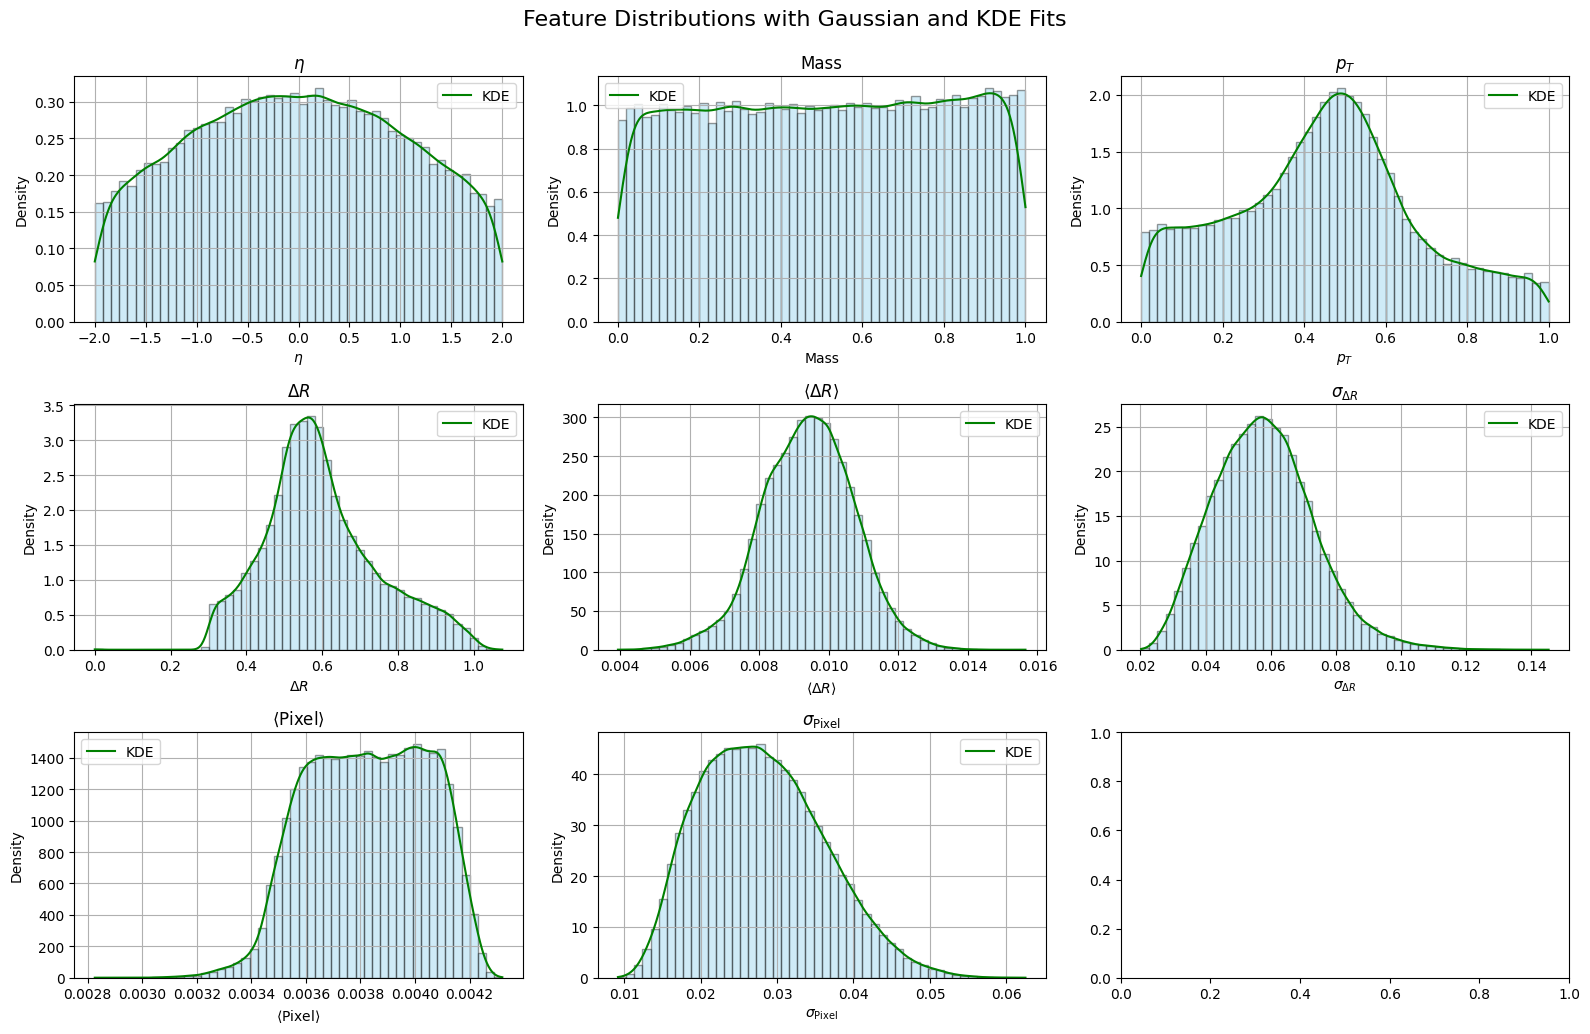

Number of samples: 87266
Image shape: torch.Size([87266, 16, 16])
Feature shape: torch.Size([87266, 9])


In [5]:
batch_size = 128*3
n_events = int(.1 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

In [ ]:
latent_dim = 256
lr = 10e-4
n_epochs = 300
num = 4

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (16, 16)
H, W = (16, 16)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0)  # [1, 16, 16]

tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

In [ ]:
## Load a previous model
# Replace with the desired filename
load_path = "models/Q_gan_model_20250712_224355.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
generator.load_state_dict(checkpoint["generator_state_dict"])
discriminator.load_state_dict(checkpoint["discriminator_state_dict"])

# Optionally restore tracking data
g_losses = checkpoint["g_losses"]
d_losses = checkpoint["d_losses"]

tracked_fake_dR_mean = checkpoint["tracked_fake_dR_mean"]
tracked_fake_dR_std = checkpoint["tracked_fake_dR_std"]
tracked_fake_pixel_mean = checkpoint["tracked_fake_pixel_mean"]
tracked_fake_pixel_std = checkpoint["tracked_fake_pixel_std"]

tracked_real_dR_mean = checkpoint["tracked_real_dR_mean"]
tracked_real_dR_std = checkpoint["tracked_real_dR_std"]
tracked_real_pixel_mean = checkpoint["tracked_real_pixel_mean"]
tracked_real_pixel_std = checkpoint["tracked_real_pixel_std"]

print(f"Loaded model from {load_path}")

[Epoch 1/300] [D loss: 0.6812] [G loss: 0.0738] [Validity_loss: 0.0687] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0051]
Sample feature coding: [ 0.         -0.57264686  0.76719236  0.06429403  0.5901355   0.00950575
  0.10653744  0.00398817  0.0281704 ]


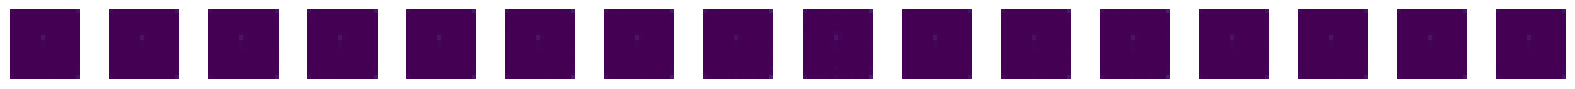

[Epoch 2/300] [D loss: 0.6969] [G loss: 0.0721] [Validity_loss: 0.0710] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0011]
Sample feature coding: [ 1.         -1.3899322   0.7061116   0.19842419  0.9201202   0.01014516
  0.03242448  0.00373929  0.02664656]


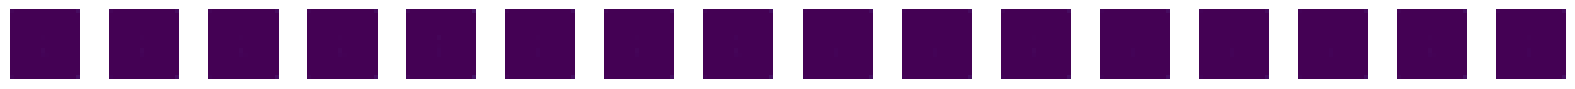

[Epoch 3/300] [D loss: 0.7052] [G loss: 0.0686] [Validity_loss: 0.0674] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0011]
Sample feature coding: [0.         1.149841   0.798193   0.01718033 0.94068015 0.00613666
 0.03512825 0.00379429 0.03218778]


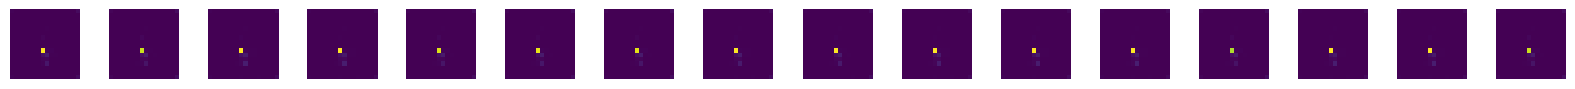

[Epoch 4/300] [D loss: 0.6839] [G loss: 0.0731] [Validity_loss: 0.0722] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0009]
Sample feature coding: [ 1.         -0.16021429  0.9985367   0.28487068  0.89595515  0.00852356
  0.05414082  0.00361981  0.02804186]


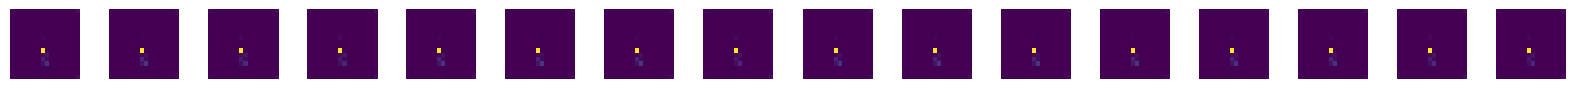

[Epoch 5/300] [D loss: 0.6831] [G loss: 0.0703] [Validity_loss: 0.0693] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0009]
Sample feature coding: [0.         1.073188   0.596471   0.3599285  0.78674257 0.00822831
 0.06864259 0.00356202 0.024065  ]


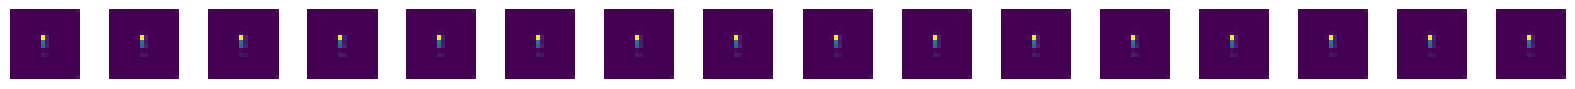

[Epoch 6/300] [D loss: 0.6945] [G loss: 0.0703] [Validity_loss: 0.0694] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0009]
Sample feature coding: [ 0.         -0.4732351   0.60691386  0.7278155   0.64023846  0.00818595
  0.05511406  0.0037275   0.02254502]


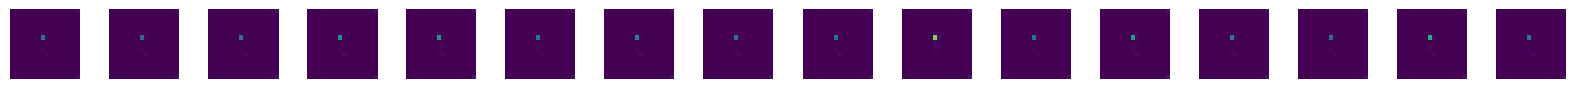

[Epoch 7/300] [D loss: 0.7079] [G loss: 0.0679] [Validity_loss: 0.0670] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0008]
Sample feature coding: [ 0.         -0.6767252   0.58339924  0.6173907   0.40583226  0.01042413
  0.04496346  0.00347937  0.01538464]


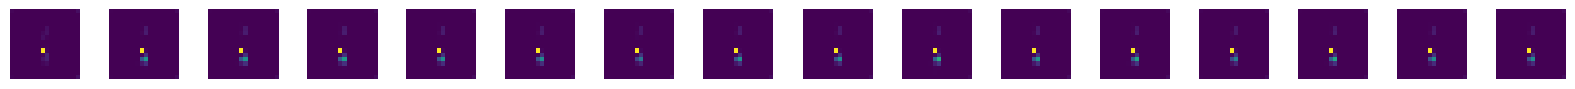

[Epoch 8/300] [D loss: 0.6874] [G loss: 0.0730] [Validity_loss: 0.0724] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.08110229 0.18719056 0.45733535 0.50318277 0.00931997
 0.07735574 0.00378883 0.02798481]


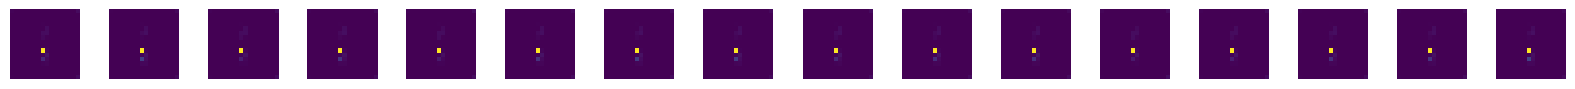

[Epoch 9/300] [D loss: 0.6932] [G loss: 0.0703] [Validity_loss: 0.0697] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         0.15771066 0.48471984 0.13127145 0.42375675 0.01059482
 0.0418983  0.00380721 0.03405442]


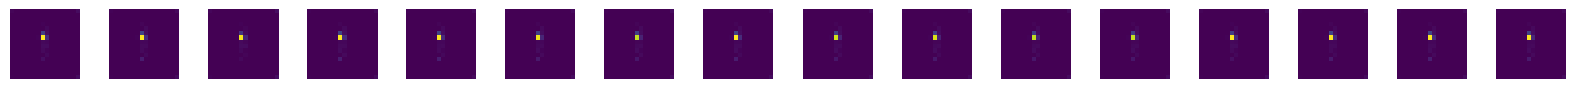

[Epoch 10/300] [D loss: 0.6922] [G loss: 0.0681] [Validity_loss: 0.0675] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0006]
Sample feature coding: [1.         0.46692696 0.16400912 0.6062609  0.540653   0.01148642
 0.05036569 0.00344607 0.03047312]


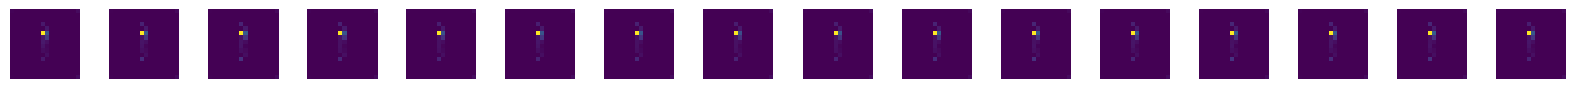

[Epoch 11/300] [D loss: 0.6931] [G loss: 0.0703] [Validity_loss: 0.0695] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [0.         0.03654425 0.5976753  0.23605645 0.7735595  0.01151743
 0.05059387 0.00406278 0.02314342]


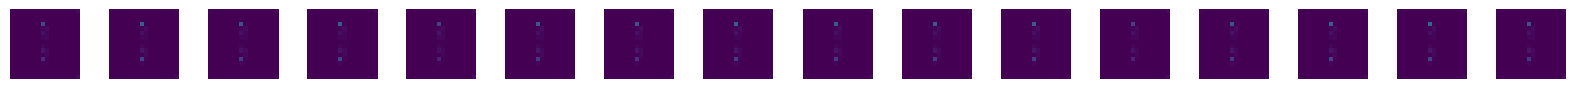

[Epoch 12/300] [D loss: 0.6896] [G loss: 0.0714] [Validity_loss: 0.0708] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         1.9235765  0.31236327 0.33181393 0.48185912 0.00799108
 0.04801788 0.00389313 0.03220667]


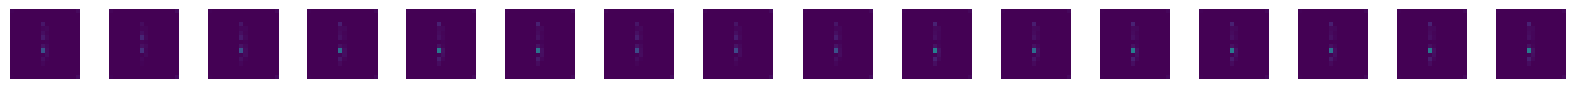

[Epoch 13/300] [D loss: 0.6856] [G loss: 0.0706] [Validity_loss: 0.0699] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         1.969444   0.5727999  0.86523336 0.32515234 0.00940196
 0.05593307 0.00350093 0.01571588]


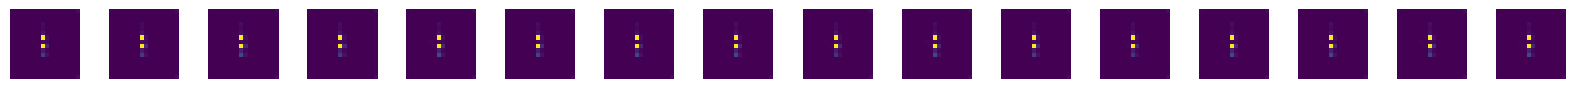

[Epoch 14/300] [D loss: 0.6933] [G loss: 0.0713] [Validity_loss: 0.0706] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -0.96426165  0.09067266  0.2218614   0.8110441   0.01023414
  0.08046144  0.0033589   0.03221235]


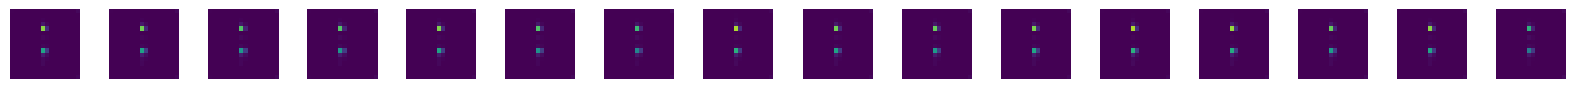

[Epoch 15/300] [D loss: 0.6898] [G loss: 0.0711] [Validity_loss: 0.0704] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.36555678 0.1147909  0.5148262  0.69978726 0.01285889
 0.05081184 0.00397473 0.02486986]


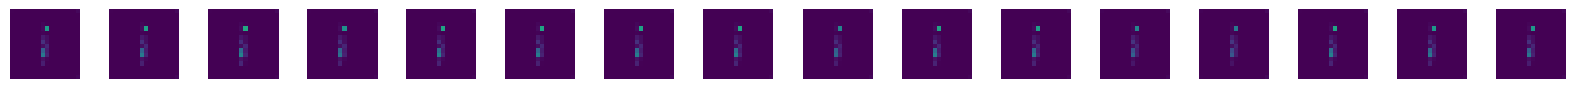

[Epoch 16/300] [D loss: 0.6925] [G loss: 0.0740] [Validity_loss: 0.0733] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 0.         -0.2150603   0.6337615   0.45020947  0.86068314  0.00835767
  0.03896488  0.00378502  0.02368441]


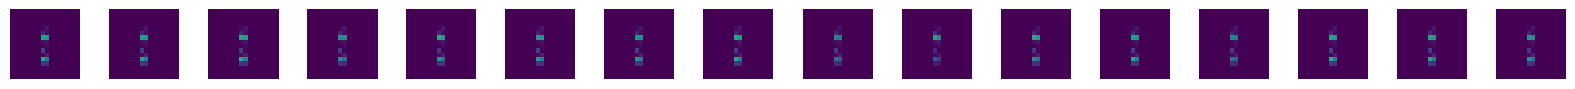

[Epoch 17/300] [D loss: 0.6908] [G loss: 0.0708] [Validity_loss: 0.0701] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         0.7163359  0.65179896 0.22415525 0.31228378 0.0064108
 0.06666112 0.00404225 0.03883548]


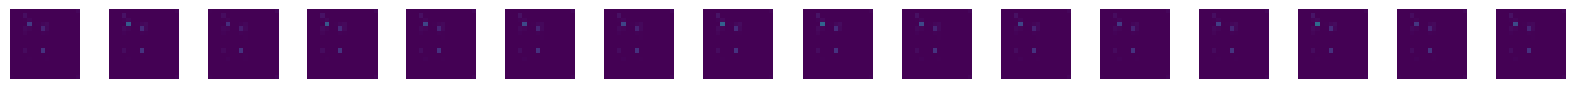

[Epoch 18/300] [D loss: 0.6822] [G loss: 0.0711] [Validity_loss: 0.0703] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [ 1.         -0.7096122   0.7441944   0.4574586   0.6492785   0.00782142
  0.04520195  0.00363384  0.01890854]


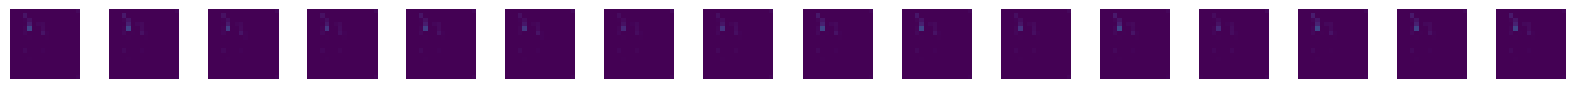

[Epoch 19/300] [D loss: 0.6899] [G loss: 0.0710] [Validity_loss: 0.0702] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [1.         0.874136   0.5607099  0.68942684 0.6998639  0.00674315
 0.03761736 0.00376262 0.02622573]


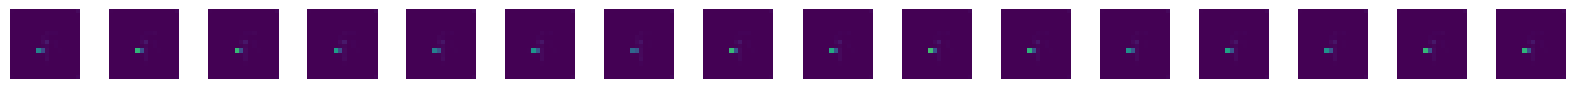

[Epoch 20/300] [D loss: 0.6961] [G loss: 0.0697] [Validity_loss: 0.0690] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 0.         -0.9428313   0.4548893   0.08619462  0.63421255  0.01001868
  0.04287168  0.00386073  0.02322432]


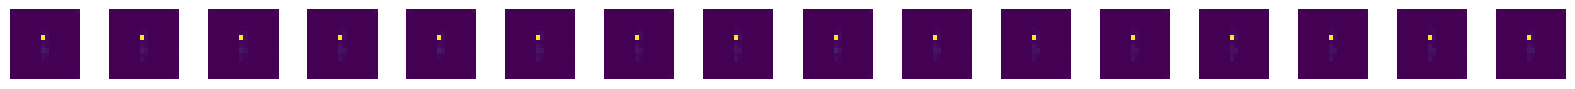

[Epoch 21/300] [D loss: 0.6942] [G loss: 0.0703] [Validity_loss: 0.0696] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         1.8978695  0.1688215  0.54977244 0.6442485  0.01037197
 0.0419479  0.00349115 0.01886395]


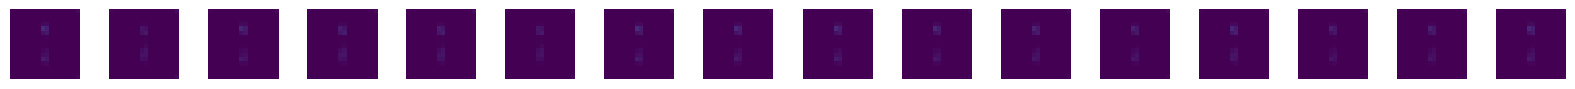

[Epoch 22/300] [D loss: 0.6859] [G loss: 0.0707] [Validity_loss: 0.0700] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.16059075 0.30043596 0.3051514  0.4723933  0.0120767
 0.09606218 0.00408667 0.02802414]


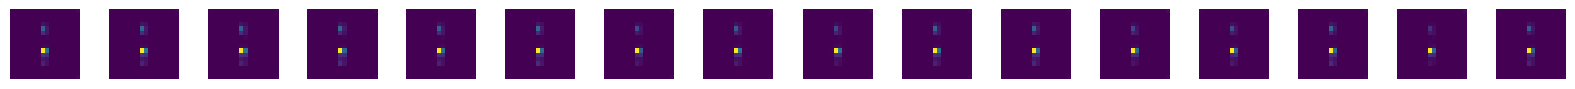

[Epoch 23/300] [D loss: 0.6705] [G loss: 0.0747] [Validity_loss: 0.0738] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0009]
Sample feature coding: [ 0.         -0.5656801   0.17527461  0.74984956  0.49827132  0.00982919
  0.04776132  0.00388245  0.02060778]


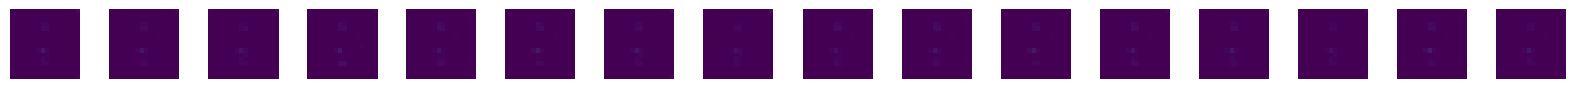

[Epoch 24/300] [D loss: 0.6837] [G loss: 0.0729] [Validity_loss: 0.0721] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -1.4519092   0.5238288   0.20625496  0.5896156   0.010367
  0.03662608  0.00380798  0.02950068]


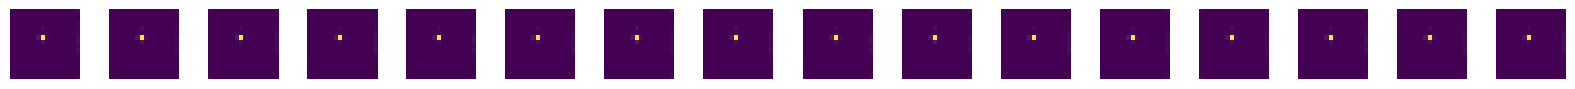

[Epoch 25/300] [D loss: 0.7095] [G loss: 0.0653] [Validity_loss: 0.0641] 
 [Stat_loss: 0.0006] [NNZ_loss: 0.0006]
Sample feature coding: [ 0.         -1.454715    0.9474188   0.35074386  0.93176687  0.00821197
  0.0506671   0.00412963  0.02299809]


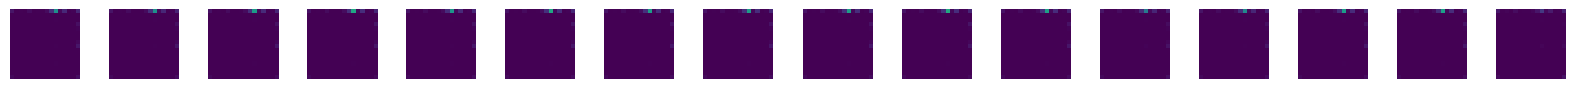

[Epoch 26/300] [D loss: 0.6739] [G loss: 0.0761] [Validity_loss: 0.0755] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         1.2823669  0.21514641 0.38495532 0.5521453  0.00782045
 0.06709139 0.00417502 0.01988218]


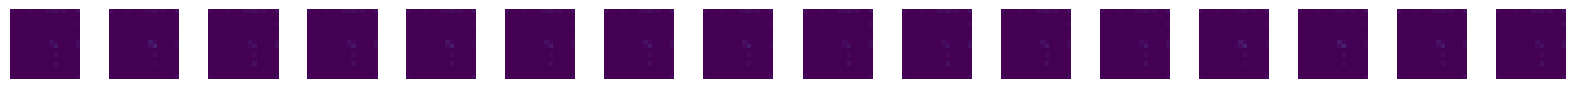

[Epoch 27/300] [D loss: 0.5940] [G loss: 0.1275] [Validity_loss: 0.1245] 
 [Stat_loss: 0.0022] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -0.94399035  0.4801326   0.64230055  0.49730617  0.01043937
  0.05650615  0.00362071  0.03814049]


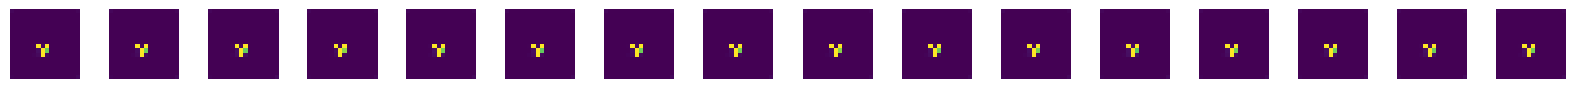

[Epoch 28/300] [D loss: 0.6935] [G loss: 0.0728] [Validity_loss: 0.0721] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 0.         -0.48456058  0.0018676   0.49265155  0.574713    0.01134208
  0.04584733  0.00353228  0.02355215]


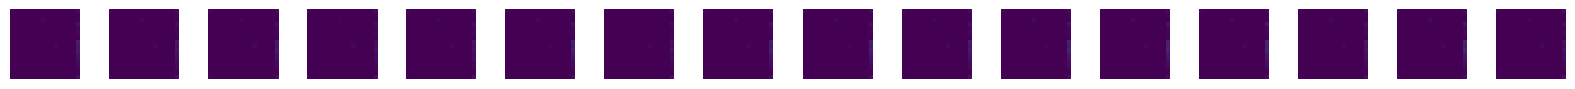

[Epoch 29/300] [D loss: 0.6898] [G loss: 0.0743] [Validity_loss: 0.0736] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.6753762  0.10938425 0.0780867  0.45559695 0.00921102
 0.06018379 0.00380318 0.02878487]


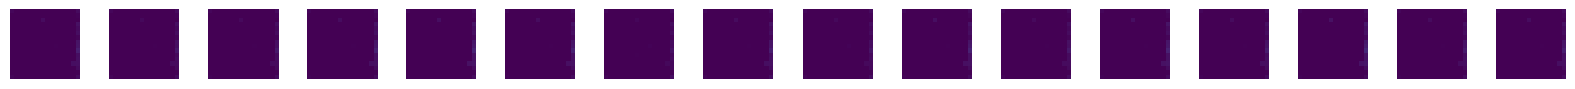

[Epoch 30/300] [D loss: 0.6651] [G loss: 0.0824] [Validity_loss: 0.0817] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.42596155 0.46337962 0.491809   0.58543056 0.01033504
 0.03828658 0.0034793  0.02090254]


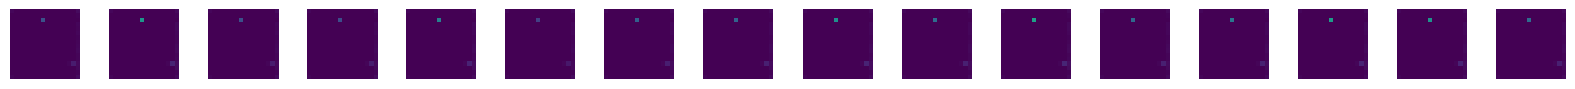

[Epoch 31/300] [D loss: 0.7217] [G loss: 0.0633] [Validity_loss: 0.0625] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [ 1.         -0.8057451   0.20861155  0.79043406  0.2957493   0.00773529
  0.05697789  0.00404876  0.03733009]


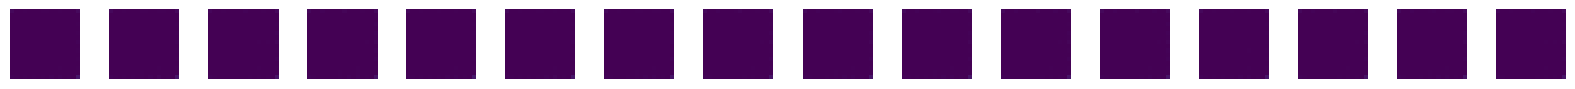

[Epoch 32/300] [D loss: 0.6991] [G loss: 0.0819] [Validity_loss: 0.0672] 
 [Stat_loss: 0.0120] [NNZ_loss: 0.0027]
Sample feature coding: [ 0.         -1.0018291   0.4985267   0.36731806  0.5686947   0.00807025
  0.04528693  0.00389385  0.04395581]


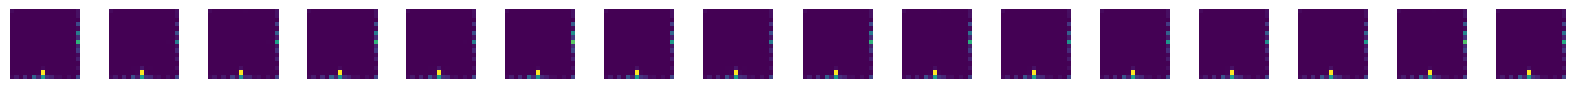

[Epoch 33/300] [D loss: 0.6860] [G loss: 0.0744] [Validity_loss: 0.0730] 
 [Stat_loss: 0.0007] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.10993267 0.12415496 0.5276581  0.80610454 0.00978943
 0.04990068 0.00366215 0.03272668]


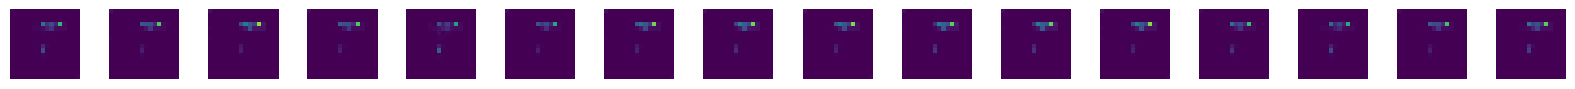

[Epoch 34/300] [D loss: 0.6706] [G loss: 0.0884] [Validity_loss: 0.0878] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         1.5243938  0.3756373  0.01575316 0.5231413  0.0101993
 0.08622318 0.00393317 0.03495099]


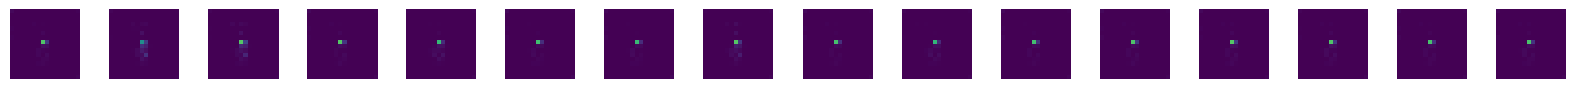

[Epoch 35/300] [D loss: 0.6843] [G loss: 0.0736] [Validity_loss: 0.0729] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         0.27009746 0.64599717 0.57460636 0.37647036 0.00995698
 0.08649477 0.00383323 0.03006768]


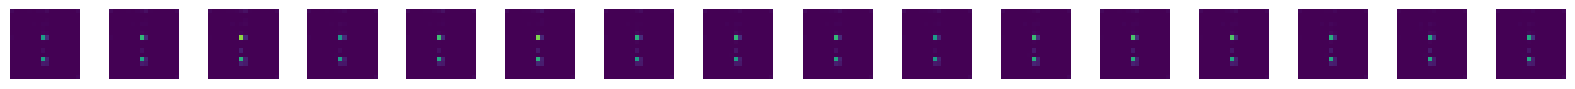

[Epoch 36/300] [D loss: 0.6768] [G loss: 0.0766] [Validity_loss: 0.0760] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         1.3956316  0.32700616 0.05369996 0.7049335  0.01183121
 0.04681519 0.00376145 0.03402186]


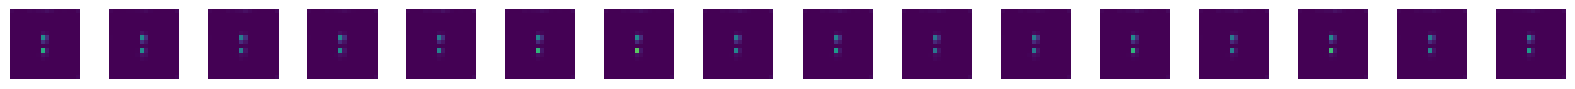

[Epoch 37/300] [D loss: 0.6651] [G loss: 0.0761] [Validity_loss: 0.0752] 
 [Stat_loss: 0.0003] [NNZ_loss: 0.0007]
Sample feature coding: [1.         0.01077149 0.48139924 0.45624134 0.63818556 0.00940274
 0.04566834 0.00360686 0.02092467]


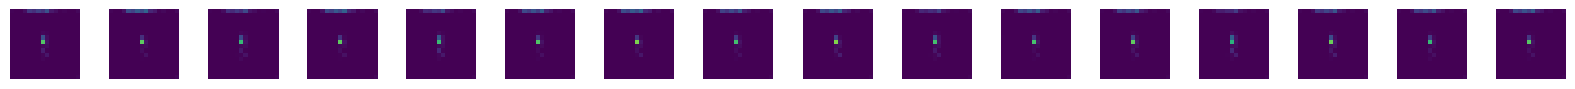

[Epoch 38/300] [D loss: 0.6498] [G loss: 0.0838] [Validity_loss: 0.0821] 
 [Stat_loss: 0.0010] [NNZ_loss: 0.0007]
Sample feature coding: [ 0.         -0.36495322  0.508811    0.6560796   0.81377715  0.00698555
  0.07745936  0.00345505  0.02468432]


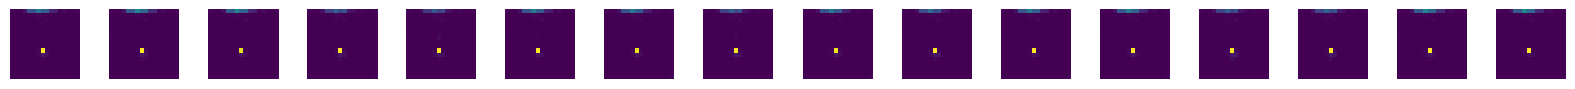

[Epoch 39/300] [D loss: 0.6453] [G loss: 0.0873] [Validity_loss: 0.0866] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 0.         -1.5241879   0.66505855  0.47919935  0.4735422   0.00958369
  0.03636647  0.00364091  0.02176408]


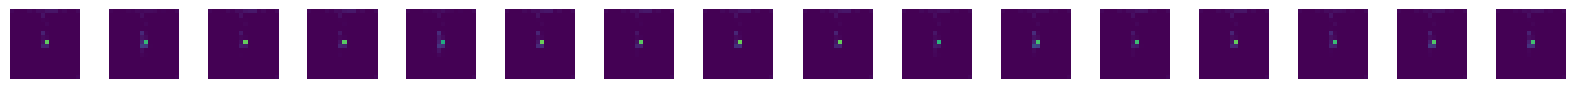

[Epoch 40/300] [D loss: 0.6879] [G loss: 0.0664] [Validity_loss: 0.0657] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 1.         -0.9264685   0.29295143  0.5061196   0.5205715   0.00877838
  0.06194748  0.0035946   0.01786495]


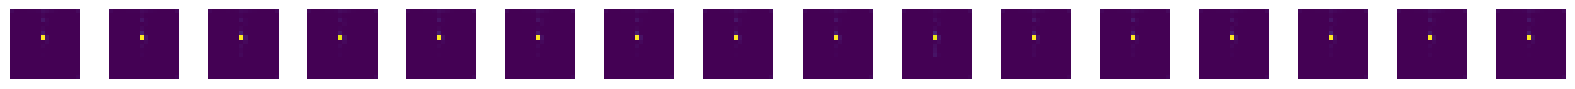

[Epoch 41/300] [D loss: 0.6658] [G loss: 0.0808] [Validity_loss: 0.0802] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 1.         -0.02491266  0.4110923   0.50391763  0.9071056   0.00731387
  0.05552703  0.00360709  0.0365808 ]


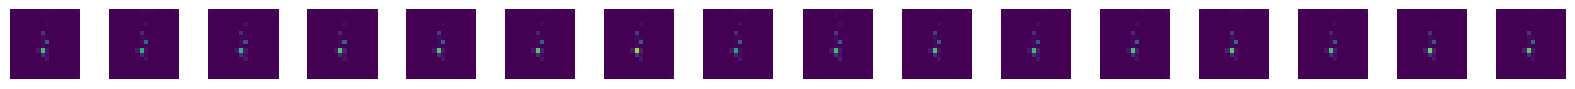

[Epoch 42/300] [D loss: 0.6722] [G loss: 0.0785] [Validity_loss: 0.0778] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 0.0000000e+00 -1.9877240e-04  3.7586406e-01  1.6281335e-01
  9.8674852e-01  9.1177858e-03  3.7250489e-02  3.6526013e-03
  2.9297132e-02]


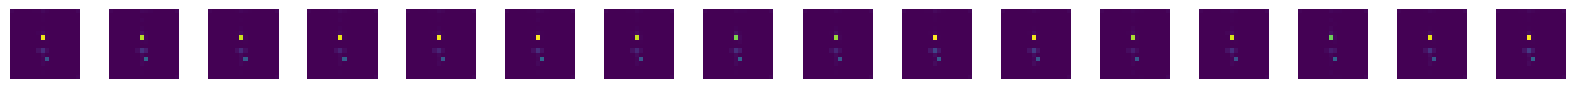

[Epoch 43/300] [D loss: 0.6633] [G loss: 0.0804] [Validity_loss: 0.0797] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -0.9626917   0.53488624  0.46610805  0.6948362   0.00885118
  0.0764218   0.00347787  0.02945914]


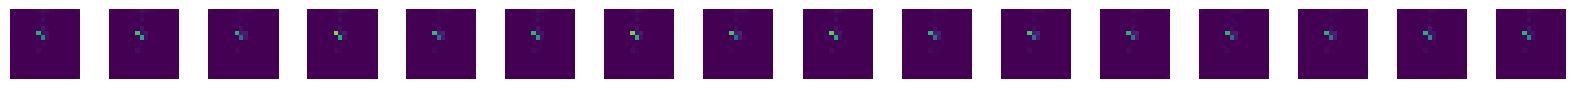

[Epoch 44/300] [D loss: 0.6960] [G loss: 0.0738] [Validity_loss: 0.0730] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -1.0117157   0.92708075  0.52902263  0.59742826  0.01058973
  0.08568641  0.00396144  0.02762641]


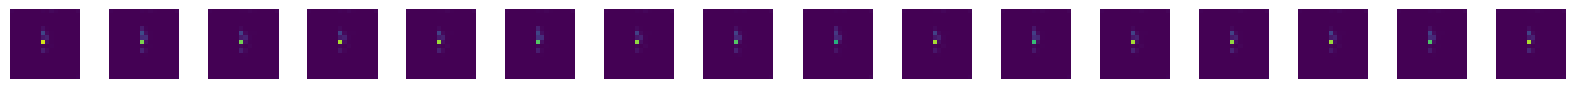

[Epoch 45/300] [D loss: 0.6714] [G loss: 0.0772] [Validity_loss: 0.0766] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 0.         -1.2468287   0.9647794   0.42032558  0.5629601   0.00954724
  0.03733226  0.00390765  0.01782106]


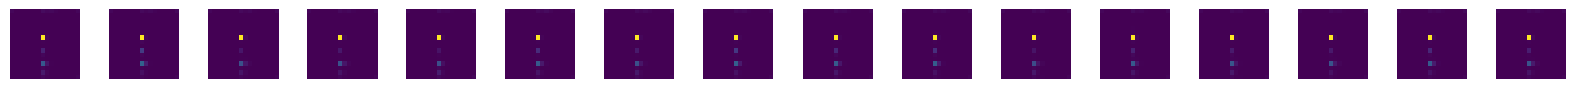

[Epoch 46/300] [D loss: 0.6845] [G loss: 0.0775] [Validity_loss: 0.0766] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0008]
Sample feature coding: [0.         1.4151262  0.32231426 0.50698984 0.70253026 0.00803064
 0.03441561 0.00382625 0.03816295]


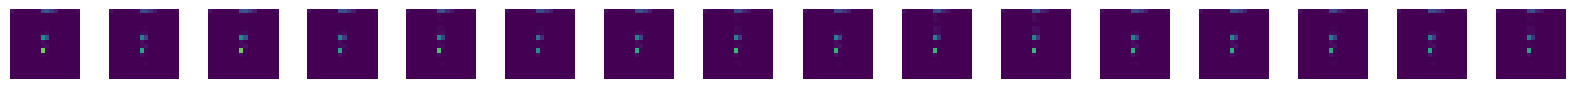

[Epoch 47/300] [D loss: 0.6704] [G loss: 0.0781] [Validity_loss: 0.0776] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 1.         -0.09665888  0.4329831   0.4299743   0.47235426  0.00783743
  0.05312273  0.00411918  0.01645019]


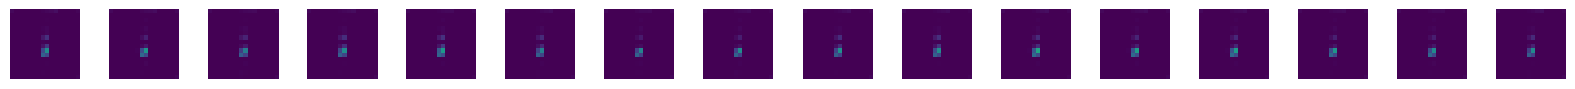

[Epoch 48/300] [D loss: 0.6599] [G loss: 0.0828] [Validity_loss: 0.0822] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0005]
Sample feature coding: [1.         1.49496    0.4393277  0.42983168 0.7108563  0.00632412
 0.05983527 0.00405143 0.03510224]


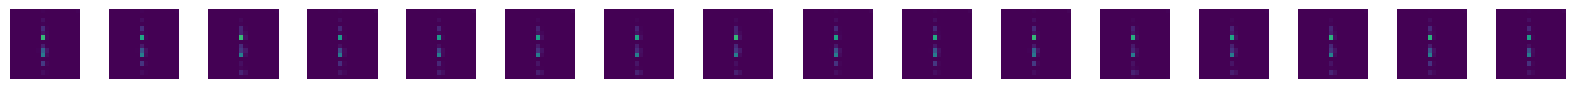

[Epoch 49/300] [D loss: 0.6619] [G loss: 0.0775] [Validity_loss: 0.0768] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         0.8852137  0.6272459  0.7665792  0.55700225 0.00967578
 0.05673517 0.00365793 0.02318625]


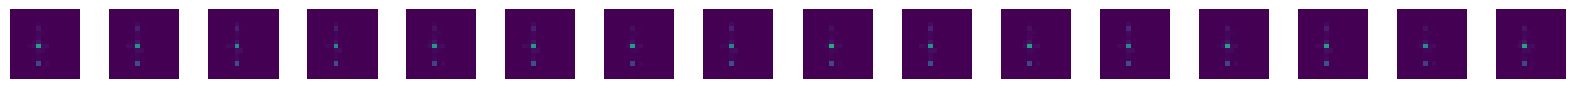

[Epoch 50/300] [D loss: 1.3046] [G loss: 0.0308] [Validity_loss: 0.0301] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -0.842849    0.3040815   0.6759493   0.5334128   0.01107293
  0.07310665  0.00399286  0.02097671]


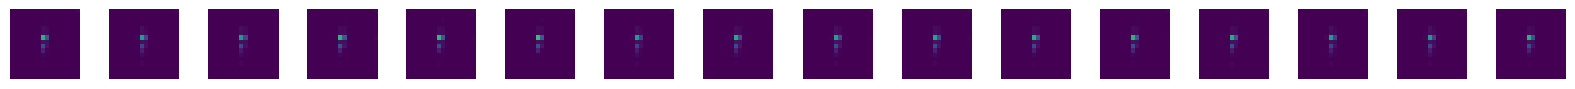

[Epoch 51/300] [D loss: 0.6775] [G loss: 0.0755] [Validity_loss: 0.0749] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0006]
Sample feature coding: [0.         1.3242787  0.0672177  0.5934528  0.5180954  0.00895523
 0.06646063 0.00372333 0.01560232]


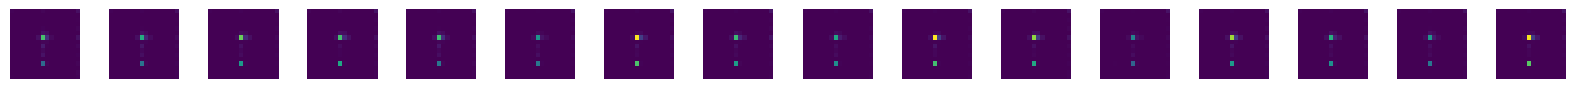

[Epoch 52/300] [D loss: 0.6734] [G loss: 0.0744] [Validity_loss: 0.0738] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         1.4555036  0.90419793 0.06739959 0.79620236 0.01074857
 0.06318509 0.00359987 0.02558403]


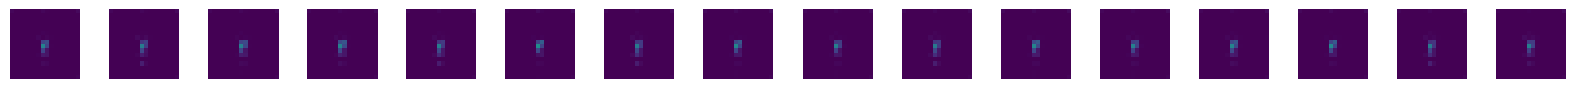

[Epoch 53/300] [D loss: 0.6790] [G loss: 0.0807] [Validity_loss: 0.0800] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         0.8387109  0.46259904 0.2674788  0.69272286 0.00531145
 0.05827102 0.0036116  0.01722988]


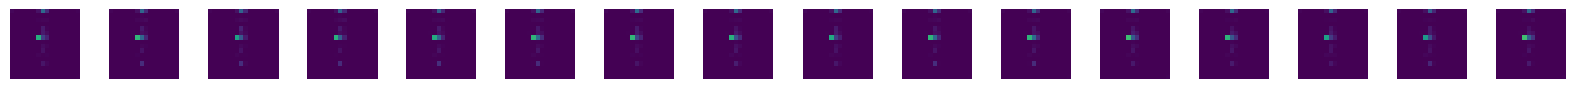

[Epoch 54/300] [D loss: 0.6855] [G loss: 0.0791] [Validity_loss: 0.0785] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0005]
Sample feature coding: [0.         1.0579883  0.8919041  0.42225784 0.71427804 0.00585672
 0.06126349 0.00365527 0.03372745]


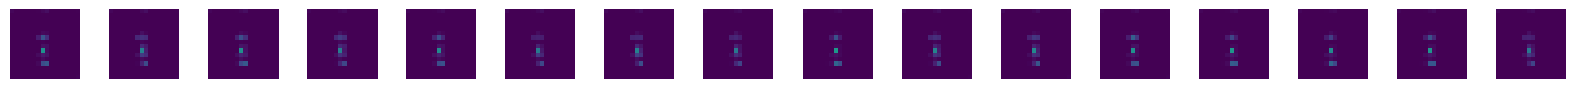

[Epoch 55/300] [D loss: 0.6672] [G loss: 0.0792] [Validity_loss: 0.0785] 
 [Stat_loss: 0.0002] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.1062222  0.7248794  0.4282887  0.4889359  0.00850509
 0.08448651 0.00367987 0.01895026]


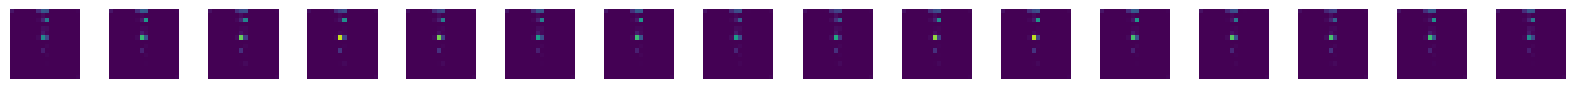

[Epoch 56/300] [D loss: 0.6640] [G loss: 0.0795] [Validity_loss: 0.0790] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0005]
Sample feature coding: [ 1.         -0.54098254  0.52385217  0.17593685  0.62431395  0.01002711
  0.06455209  0.00375539  0.0387379 ]


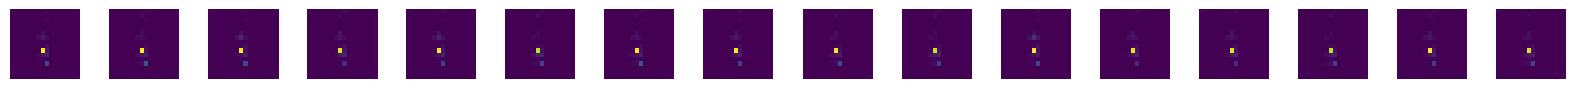

[Epoch 57/300] [D loss: 0.6552] [G loss: 0.0790] [Validity_loss: 0.0783] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0006]
Sample feature coding: [ 1.         -0.79071546  0.41971856  0.04166277  0.3068861   0.01067538
  0.05823938  0.00374184  0.01933834]


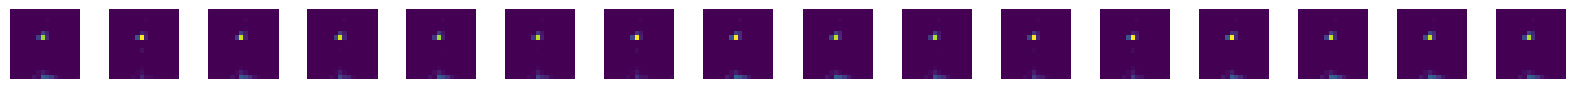

[Epoch 58/300] [D loss: 0.6656] [G loss: 0.0780] [Validity_loss: 0.0774] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 0.         -1.1860925   0.01972846  0.31087643  0.3742078   0.00853248
  0.06384367  0.0036384   0.02286218]


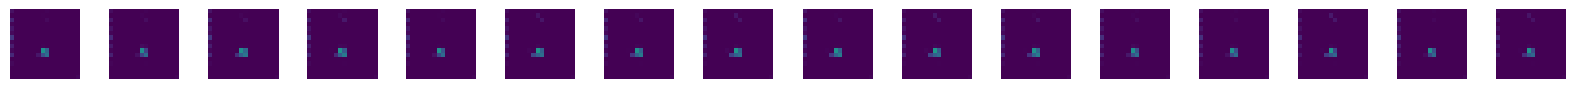

[Epoch 59/300] [D loss: 0.6734] [G loss: 0.0763] [Validity_loss: 0.0752] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0011]
Sample feature coding: [ 0.         -1.1730675   0.51331073  0.5089083   0.49013093  0.00512851
  0.06240461  0.00398136  0.02420454]


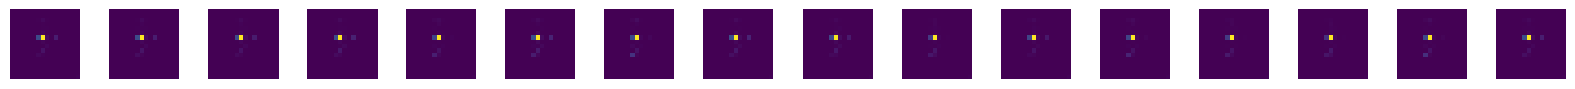

[Epoch 60/300] [D loss: 0.6555] [G loss: 0.0792] [Validity_loss: 0.0787] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0005]
Sample feature coding: [ 1.         -0.13723312  0.13917135  0.41148403  0.96633035  0.01081466
  0.06785614  0.00400156  0.04798982]


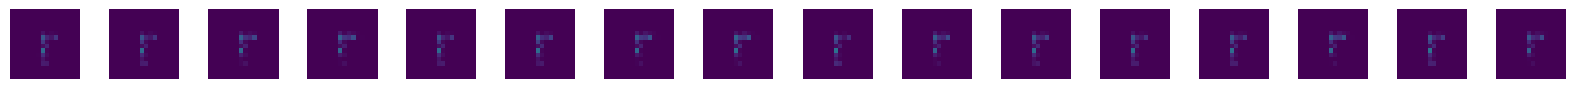

[Epoch 61/300] [D loss: 0.6702] [G loss: 0.0779] [Validity_loss: 0.0773] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         0.4069946  0.09106919 0.65662247 0.54494196 0.008998
 0.06643365 0.00377449 0.03560971]


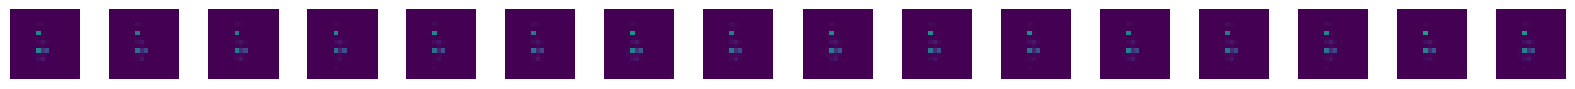

[Epoch 62/300] [D loss: 0.6582] [G loss: 0.0847] [Validity_loss: 0.0841] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.22582787 0.9455476  0.05553682 0.5784609  0.00790177
 0.08008431 0.00390236 0.02361635]


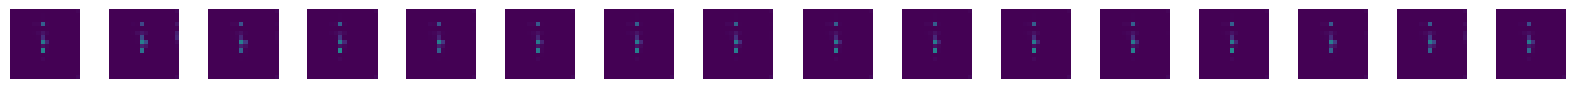

[Epoch 63/300] [D loss: 0.6600] [G loss: 0.0826] [Validity_loss: 0.0819] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         0.3789361  0.03395656 0.44334915 0.5255633  0.01020632
 0.04587804 0.00383739 0.02571169]


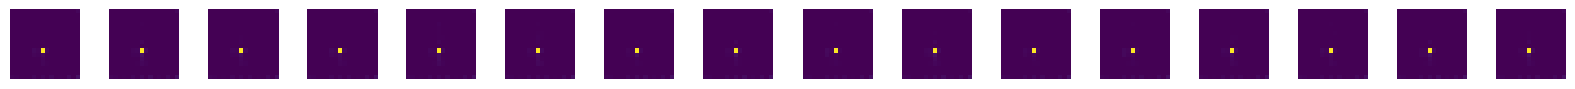

[Epoch 64/300] [D loss: 0.6253] [G loss: 0.0900] [Validity_loss: 0.0893] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [0.         0.69428676 0.697073   0.4722666  0.6664305  0.0102993
 0.07153241 0.00391593 0.02535292]


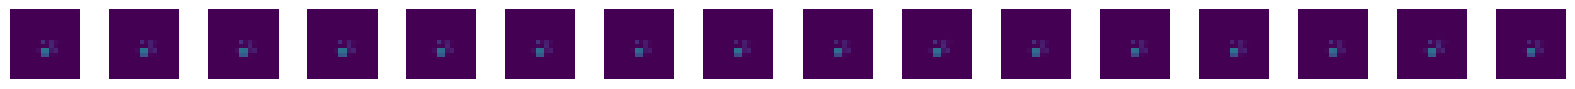

[Epoch 65/300] [D loss: 0.6677] [G loss: 0.0813] [Validity_loss: 0.0807] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0005]
Sample feature coding: [0.         0.27955285 0.6085408  0.17213058 0.51289386 0.01039939
 0.05302268 0.00362594 0.02652655]


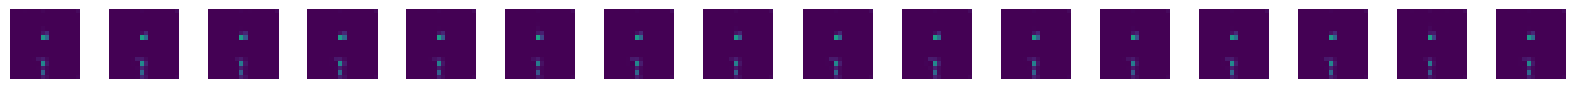

[Epoch 66/300] [D loss: 0.6717] [G loss: 0.0775] [Validity_loss: 0.0770] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0005]
Sample feature coding: [ 0.         -0.93579316  0.9536048   0.82431036  0.55504733  0.0088272
  0.09373505  0.00379758  0.02144559]


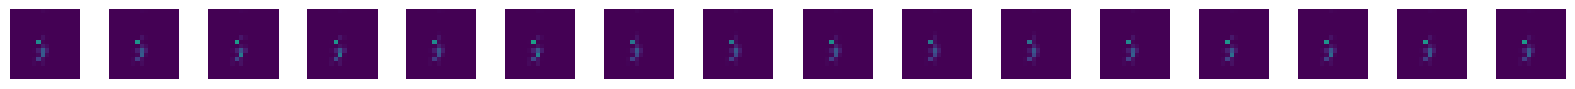

[Epoch 67/300] [D loss: 0.6742] [G loss: 0.0824] [Validity_loss: 0.0816] 
 [Stat_loss: 0.0002] [NNZ_loss: 0.0006]
Sample feature coding: [1.         0.20432551 0.52208906 0.29871145 0.4382474  0.00933676
 0.05156308 0.00405168 0.02906124]


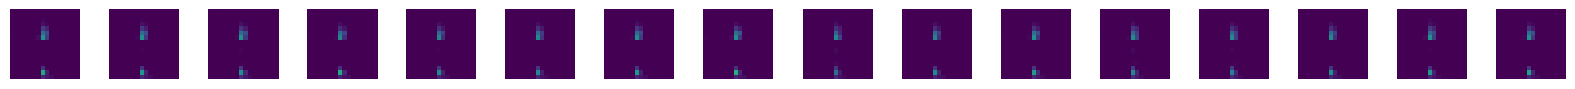

[Epoch 68/300] [D loss: 0.6585] [G loss: 0.0787] [Validity_loss: 0.0780] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [0.         0.16711506 0.10862213 0.5866277  0.8712096  0.01019003
 0.11768749 0.00390881 0.02822727]


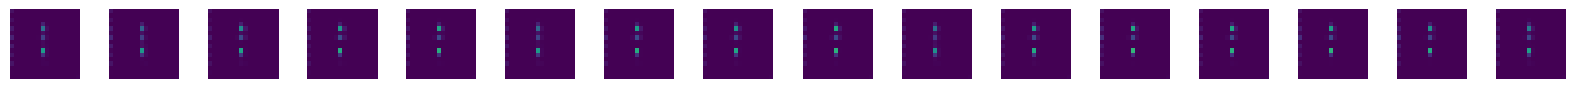

[Epoch 69/300] [D loss: 0.6677] [G loss: 0.0831] [Validity_loss: 0.0825] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.5007896  0.02678603 0.79052895 0.7991441  0.01143841
 0.03477817 0.00375868 0.03237198]


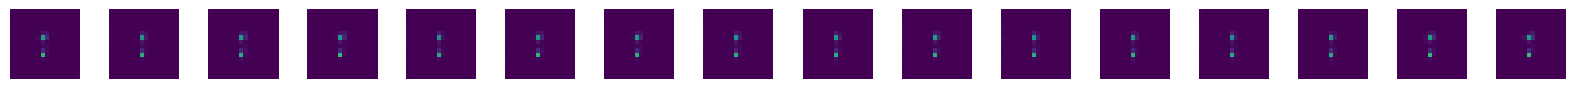

[Epoch 70/300] [D loss: 0.6389] [G loss: 0.0818] [Validity_loss: 0.0812] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         1.8152232  0.15047637 0.22980049 0.5070078  0.01570018
 0.04921052 0.00388601 0.04418927]


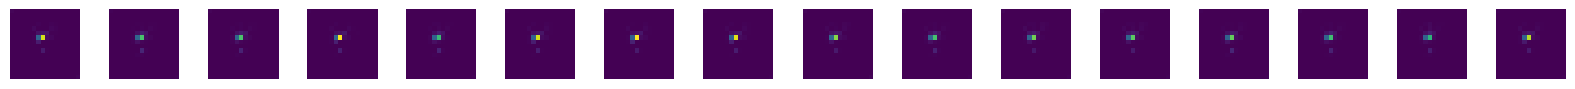

[Epoch 71/300] [D loss: 0.6712] [G loss: 0.0811] [Validity_loss: 0.0806] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 1.         -0.63217884  0.77293056  0.37698606  0.66867363  0.00664729
  0.06625088  0.00392199  0.02218036]


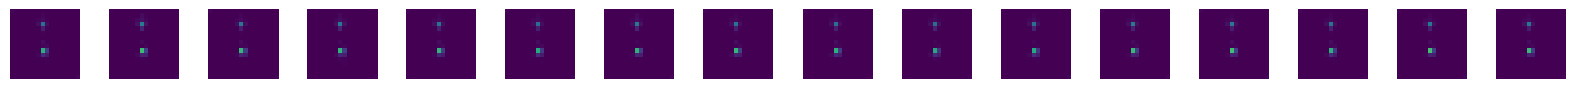

[Epoch 72/300] [D loss: 0.6542] [G loss: 0.0809] [Validity_loss: 0.0803] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 1.          1.8286194  -0.03115327  0.42301223  0.69246656  0.00633618
  0.02946815  0.00365891  0.0340934 ]


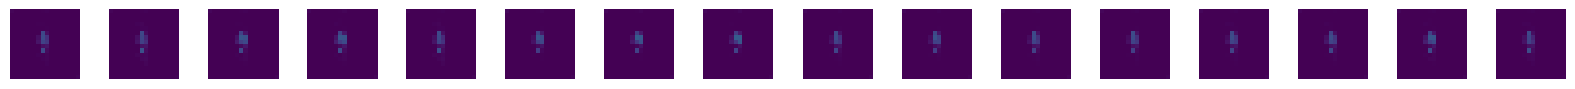

[Epoch 73/300] [D loss: 0.6606] [G loss: 0.0787] [Validity_loss: 0.0781] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         1.0897611  0.6607641  0.569706   1.013821   0.00904475
 0.05664911 0.00405869 0.03113633]


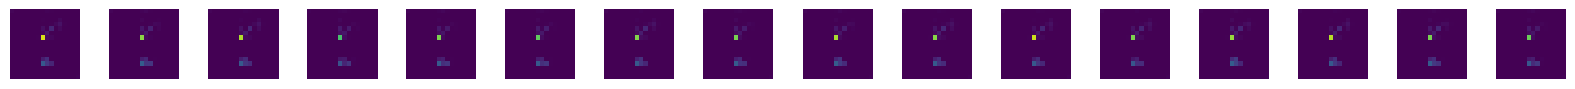

[Epoch 74/300] [D loss: 0.6700] [G loss: 0.0794] [Validity_loss: 0.0788] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         0.6953931  0.48701763 0.40095195 0.35309952 0.00824952
 0.06328546 0.00358027 0.02462855]


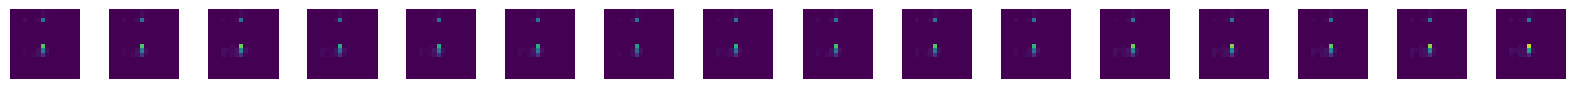

[Epoch 75/300] [D loss: 0.7230] [G loss: 0.0739] [Validity_loss: 0.0730] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0009]
Sample feature coding: [ 1.         -0.87354755  0.60832465  0.47213495  0.5408277   0.00822658
  0.06341951  0.00403205  0.01737129]


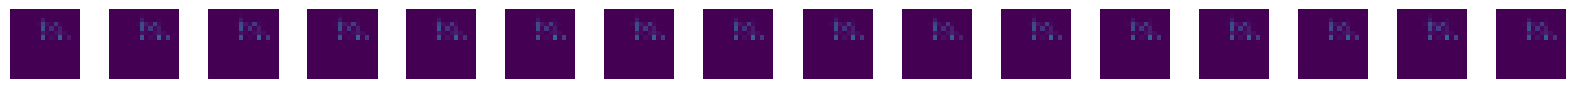

[Epoch 76/300] [D loss: 0.6481] [G loss: 0.0898] [Validity_loss: 0.0884] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0014]
Sample feature coding: [ 1.         -0.26442686  0.37306097  0.5408492   0.6186947   0.0107086
  0.05926573  0.00382917  0.01945107]


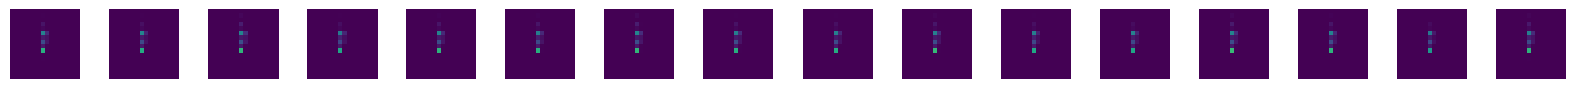

[Epoch 77/300] [D loss: 0.7117] [G loss: 0.0886] [Validity_loss: 0.0878] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [ 0.         -1.4824557   0.8629089   0.33336642  0.49557704  0.00996041
  0.05727195  0.00393181  0.02003804]


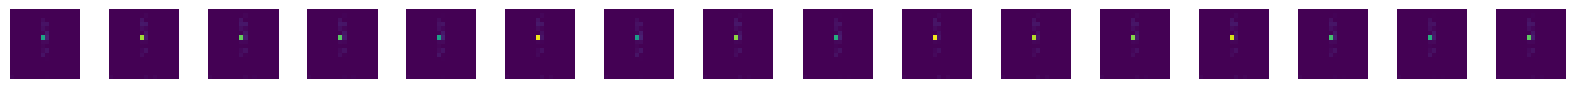

[Epoch 78/300] [D loss: 0.7140] [G loss: 0.0740] [Validity_loss: 0.0734] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 0.         -0.5067258   0.8847398   0.04222226  0.41365853  0.00953279
  0.04683871  0.00344821  0.01938877]


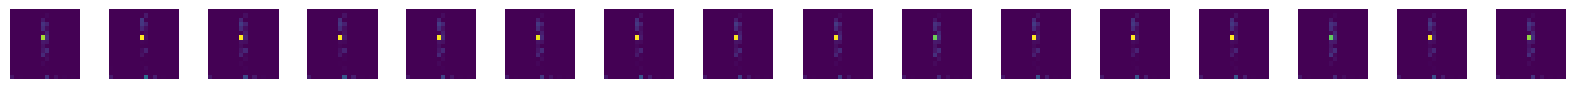

[Epoch 79/300] [D loss: 0.6866] [G loss: 0.0671] [Validity_loss: 0.0657] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0014]
Sample feature coding: [1.         0.52200675 0.6112495  0.6820576  0.5192459  0.01098093
 0.06132083 0.00394501 0.02664045]


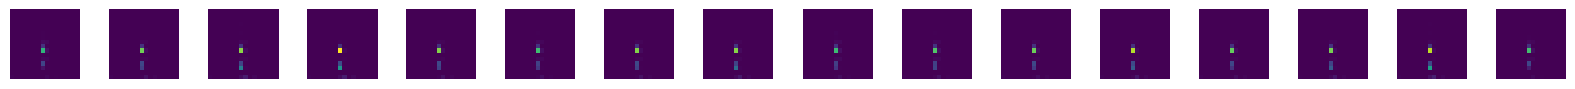

[Epoch 80/300] [D loss: 0.5032] [G loss: 0.1246] [Validity_loss: 0.1233] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0013]
Sample feature coding: [ 1.         -0.352481    0.28102222  0.37511897  0.5330498   0.00932033
  0.07088629  0.00408029  0.03422379]


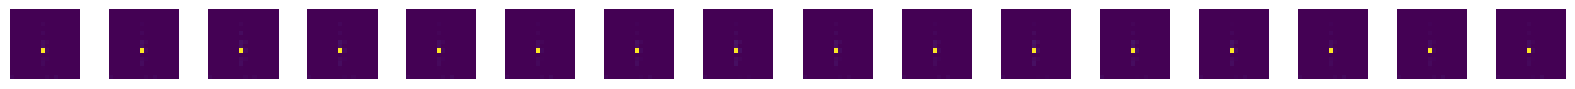

[Epoch 81/300] [D loss: 0.6402] [G loss: 0.0732] [Validity_loss: 0.0723] 
 [Stat_loss: 0.0002] [NNZ_loss: 0.0007]
Sample feature coding: [ 0.         -1.8472172   0.22673684  0.28009072  0.59496874  0.0117382
  0.03843229  0.00383752  0.02987927]


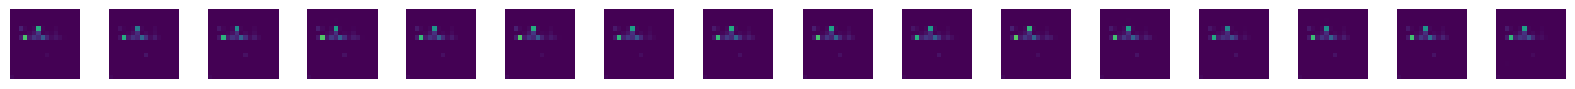

[Epoch 82/300] [D loss: 0.6481] [G loss: 0.0824] [Validity_loss: 0.0815] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0009]
Sample feature coding: [1.         1.6972612  0.5128317  0.96936595 0.6922846  0.01085385
 0.08932788 0.00390126 0.02745465]


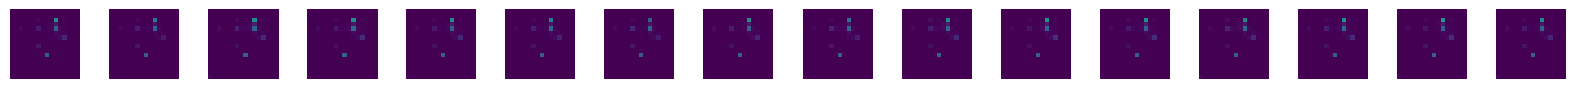

[Epoch 83/300] [D loss: 0.7471] [G loss: 0.1022] [Validity_loss: 0.0987] 
 [Stat_loss: 0.0016] [NNZ_loss: 0.0019]
Sample feature coding: [1.         1.6587931  0.57069963 0.22594152 0.5225134  0.00938456
 0.06365221 0.00403019 0.03042507]


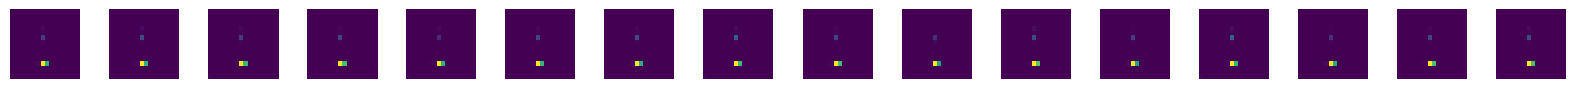

[Epoch 84/300] [D loss: 0.6365] [G loss: 0.0858] [Validity_loss: 0.0852] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         1.4507217  0.7193116  0.7354171  0.73268354 0.00892127
 0.03936664 0.00409096 0.02281803]


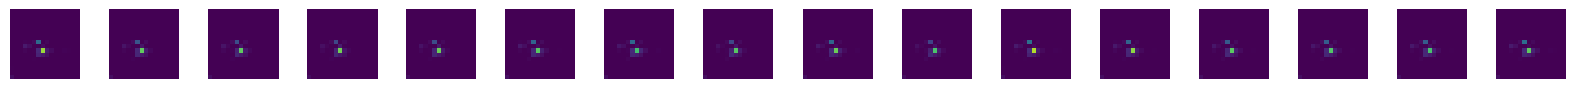

[Epoch 85/300] [D loss: 0.6552] [G loss: 0.0786] [Validity_loss: 0.0778] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         1.1890463  0.72238874 0.2968052  0.64336693 0.007937
 0.04022085 0.00377951 0.02998951]


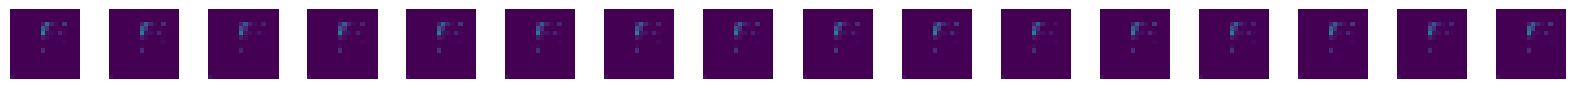

[Epoch 86/300] [D loss: 0.6668] [G loss: 0.0824] [Validity_loss: 0.0814] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0009]
Sample feature coding: [ 0.         -0.82016593  0.8386447   0.9190948   0.90365976  0.00900251
  0.06791808  0.00410762  0.02985358]


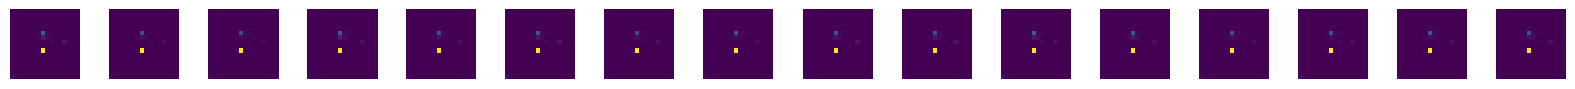

[Epoch 87/300] [D loss: 0.6966] [G loss: 0.0790] [Validity_loss: 0.0780] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0009]
Sample feature coding: [0.         1.7171177  0.27872604 0.42879307 0.42294416 0.00770264
 0.09863252 0.00363574 0.0317261 ]


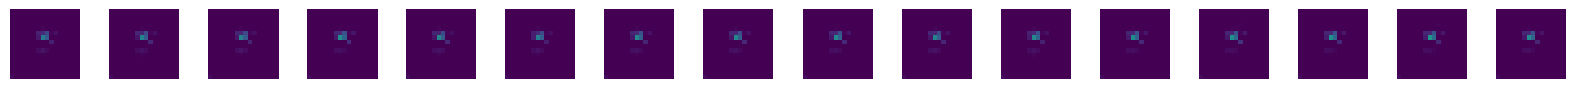

[Epoch 88/300] [D loss: 0.6791] [G loss: 0.0768] [Validity_loss: 0.0761] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 0.         -1.8944613   0.9199362   0.5370382   0.69083184  0.00828074
  0.04620351  0.00422644  0.03765365]


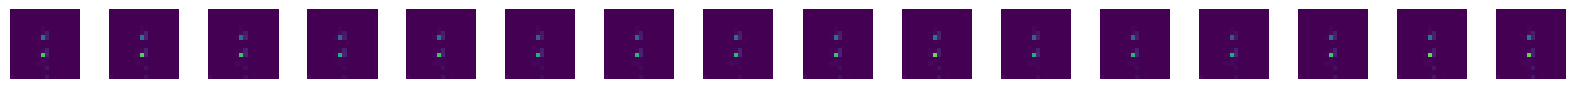

[Epoch 89/300] [D loss: 0.6698] [G loss: 0.0810] [Validity_loss: 0.0803] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         1.2253219  0.05911988 0.30169436 1.0221694  0.00891174
 0.06104935 0.00357872 0.0306051 ]


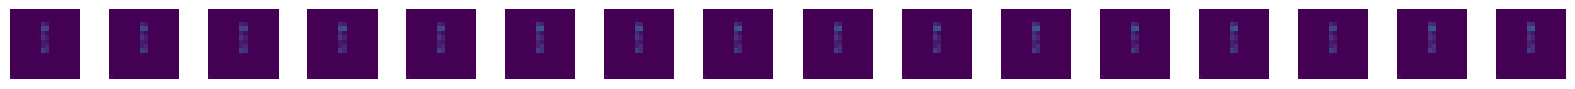

[Epoch 90/300] [D loss: 0.5433] [G loss: 0.0985] [Validity_loss: 0.0978] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -1.4335815   0.6172528   0.45053604  0.5398856   0.0077921
  0.07766991  0.00381795  0.01457403]


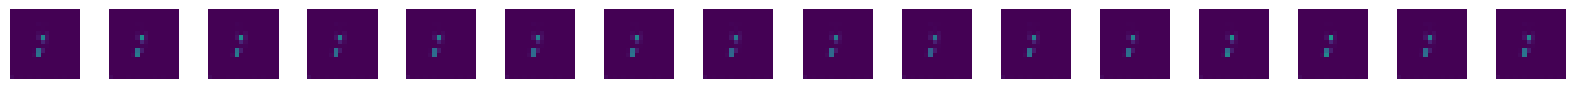

[Epoch 91/300] [D loss: 0.5858] [G loss: 0.0877] [Validity_loss: 0.0867] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0010]
Sample feature coding: [ 1.         -0.52585644  0.5929001   0.02661938  0.3228516   0.01067642
  0.06539898  0.00416588  0.02881646]


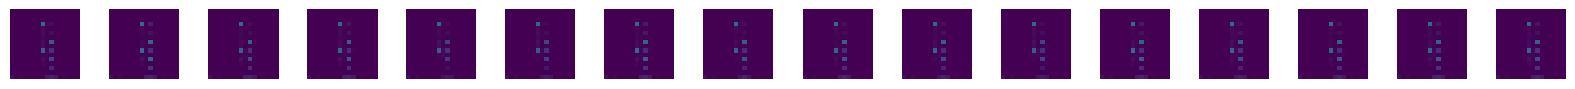

[Epoch 92/300] [D loss: 0.6412] [G loss: 0.0880] [Validity_loss: 0.0873] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         0.42947358 0.29082257 0.41688523 0.65216345 0.00765477
 0.05414798 0.0038174  0.02779355]


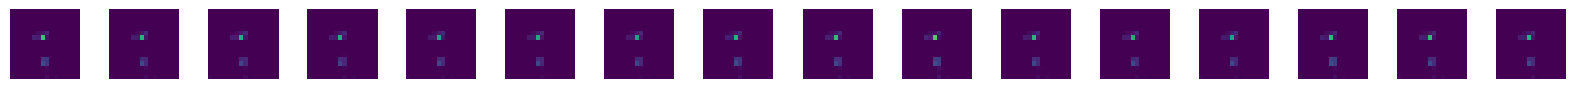

[Epoch 93/300] [D loss: 0.6507] [G loss: 0.0791] [Validity_loss: 0.0779] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0012]
Sample feature coding: [1.         1.4459976  0.32917216 0.93491775 0.60453004 0.00932576
 0.05430173 0.0041211  0.01516354]


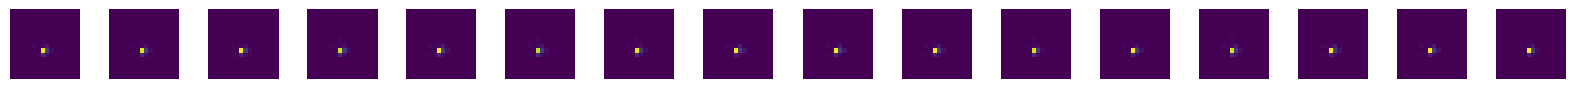

[Epoch 94/300] [D loss: 0.6470] [G loss: 0.0670] [Validity_loss: 0.0655] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0015]
Sample feature coding: [0.         1.7543149  0.35194314 0.36997032 0.72320765 0.01054937
 0.0713119  0.00365389 0.01807841]


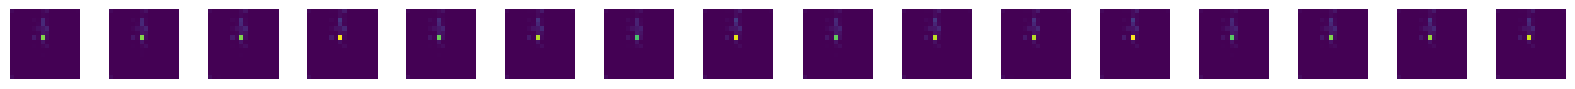

[Epoch 95/300] [D loss: 0.6415] [G loss: 0.0864] [Validity_loss: 0.0858] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         1.0678594  0.46749106 0.86201465 0.79534227 0.0116882
 0.06198449 0.00376261 0.02793377]


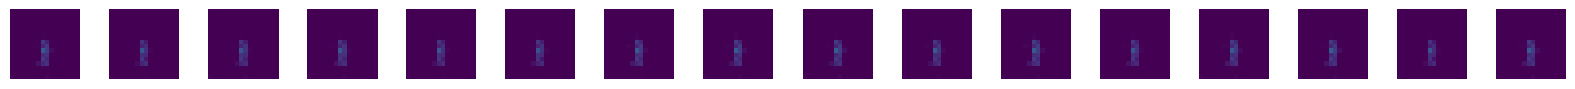

[Epoch 96/300] [D loss: 0.6474] [G loss: 0.0813] [Validity_loss: 0.0807] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         2.261815   0.23803331 0.9264795  0.5105425  0.01054314
 0.09031654 0.00381491 0.02714457]


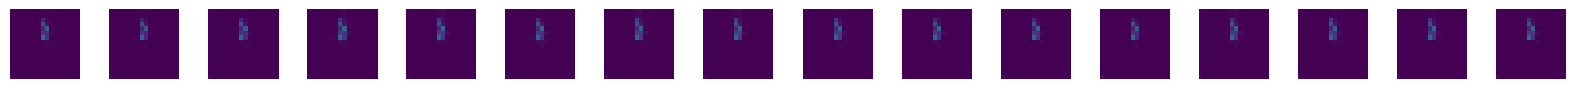

[Epoch 97/300] [D loss: 0.5064] [G loss: 0.1106] [Validity_loss: 0.1096] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0009]
Sample feature coding: [1.         0.5251788  0.20480448 0.14870018 0.5472287  0.01168641
 0.05012637 0.00391114 0.04314027]


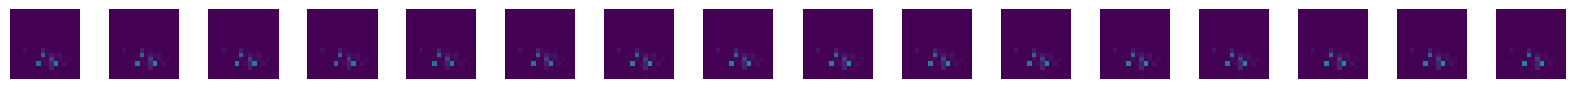

[Epoch 98/300] [D loss: 0.6956] [G loss: 0.0748] [Validity_loss: 0.0741] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         0.9211453  0.35695815 0.4772841  0.43858653 0.01014351
 0.06786474 0.00359846 0.02382028]


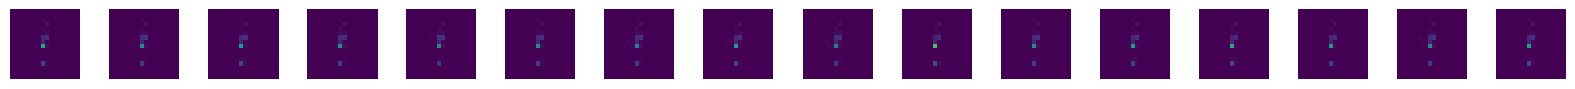

[Epoch 99/300] [D loss: 0.7443] [G loss: 0.0685] [Validity_loss: 0.0673] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0011]
Sample feature coding: [0.         0.5188916  0.21542516 0.68204635 0.36553633 0.00685724
 0.03438526 0.0035121  0.01568633]


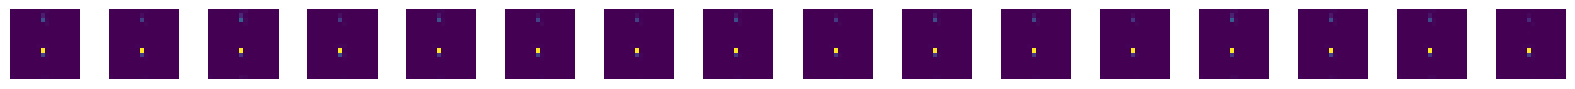

[Epoch 100/300] [D loss: 0.6704] [G loss: 0.0813] [Validity_loss: 0.0807] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         1.8924403  0.57688093 0.4721476  0.82312804 0.01194319
 0.04245303 0.00390001 0.03237277]


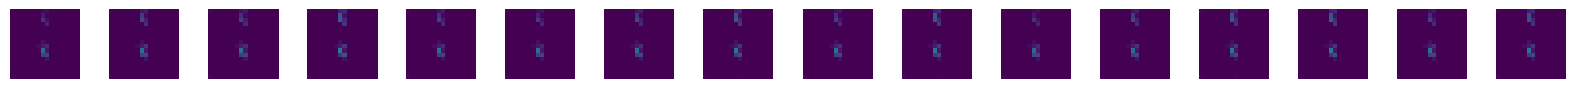

[Epoch 101/300] [D loss: 0.6479] [G loss: 0.0844] [Validity_loss: 0.0837] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         0.883823   0.9079169  0.31742173 0.5103639  0.00829708
 0.06084048 0.00367816 0.03809728]


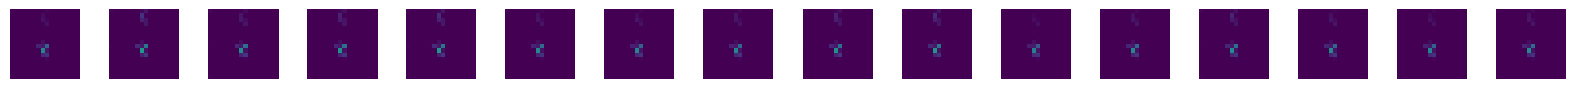

[Epoch 102/300] [D loss: 0.6182] [G loss: 0.0824] [Validity_loss: 0.0816] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [0.         0.7895364  0.603593   0.03039737 0.44299    0.01029798
 0.07618537 0.0032516  0.02996129]


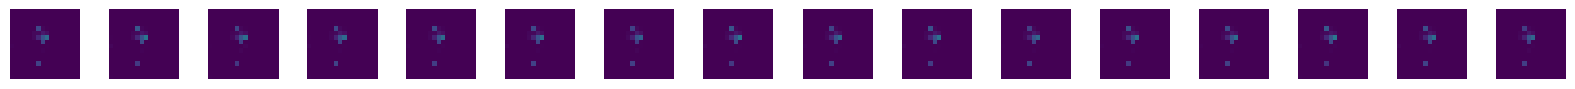

[Epoch 103/300] [D loss: 0.6973] [G loss: 0.0683] [Validity_loss: 0.0665] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0018]
Sample feature coding: [0.         1.1055164  0.40594995 0.2793009  0.80974144 0.01054899
 0.05413624 0.00354803 0.01930766]


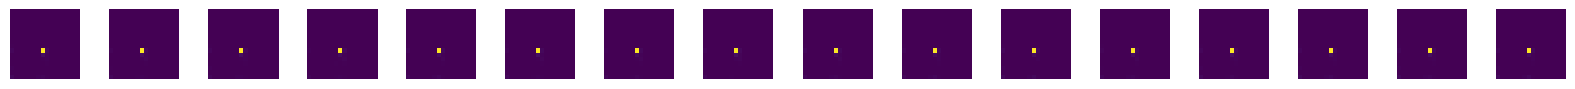

[Epoch 104/300] [D loss: 0.6538] [G loss: 0.0807] [Validity_loss: 0.0801] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.95099247 0.42521846 0.34149334 0.80181044 0.0095861
 0.05107662 0.00391201 0.01586783]


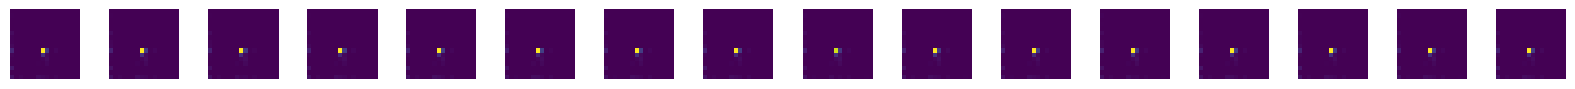

[Epoch 105/300] [D loss: 0.6827] [G loss: 0.0778] [Validity_loss: 0.0770] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [0.         0.5070111  0.70659757 0.41841072 0.6036971  0.00867805
 0.05321803 0.00395109 0.02906569]


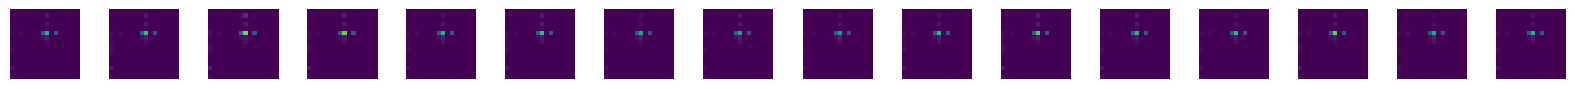

[Epoch 106/300] [D loss: 0.6381] [G loss: 0.0888] [Validity_loss: 0.0881] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -1.582583    0.37789157  0.45600435  0.9444226   0.01115909
  0.05151012  0.00369666  0.03359825]


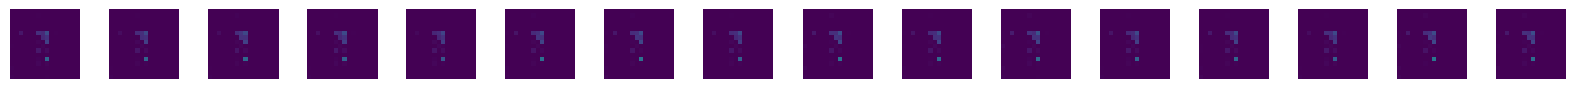

[Epoch 107/300] [D loss: 0.5732] [G loss: 0.1001] [Validity_loss: 0.0992] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [1.         0.01335385 0.3333453  0.45585674 0.6415914  0.00965896
 0.04537783 0.00356371 0.0297696 ]


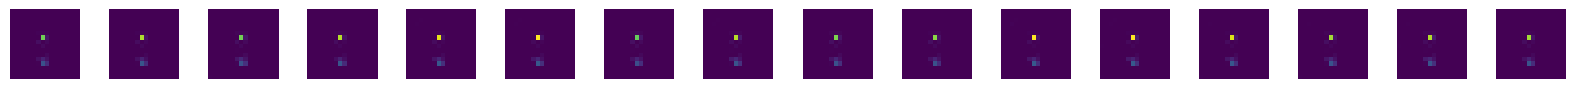

[Epoch 108/300] [D loss: 0.6953] [G loss: 0.0625] [Validity_loss: 0.0618] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         0.15811051 0.2306395  0.05875241 0.5334599  0.010515
 0.04261644 0.00357982 0.02803903]


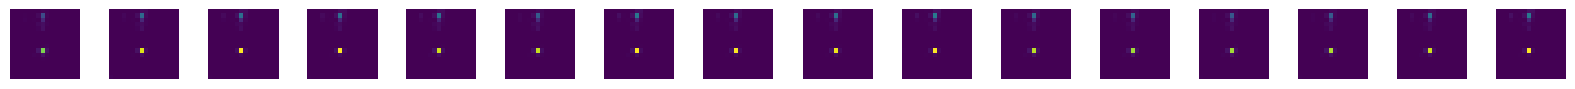

[Epoch 109/300] [D loss: 0.6481] [G loss: 0.0799] [Validity_loss: 0.0791] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0006]
Sample feature coding: [ 1.         -1.286059    0.44927636  0.20964327  0.753938    0.00937499
  0.03942425  0.00358128  0.03911116]


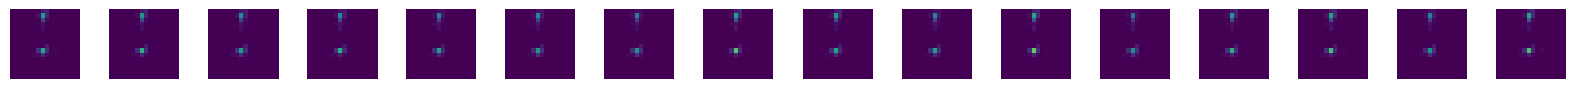

[Epoch 110/300] [D loss: 0.7028] [G loss: 0.0846] [Validity_loss: 0.0840] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.90130013 0.69785535 0.54079163 0.6473513  0.01182943
 0.06278819 0.00401778 0.0351263 ]


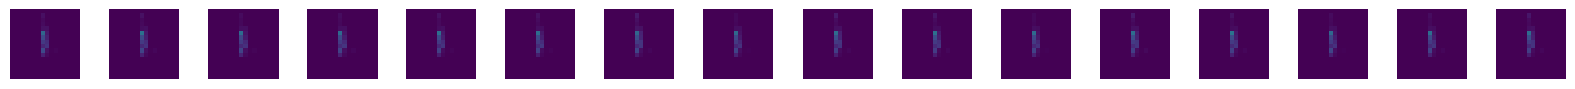

[Epoch 111/300] [D loss: 0.5814] [G loss: 0.1037] [Validity_loss: 0.1029] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [ 1.         -0.10747459  0.97912043  0.7812817   0.51373476  0.0123993
  0.07258753  0.0036295   0.01333874]


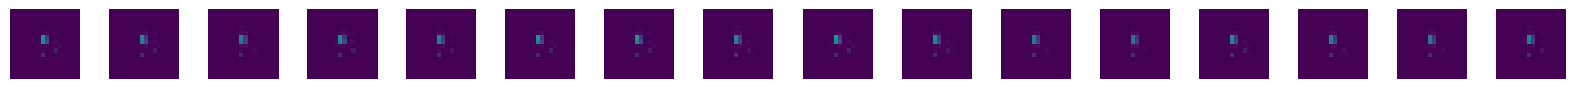

[Epoch 112/300] [D loss: 0.5696] [G loss: 0.1043] [Validity_loss: 0.1036] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         1.1498244  0.8862075  0.65936553 0.5376854  0.00824774
 0.03738293 0.00375033 0.01966912]


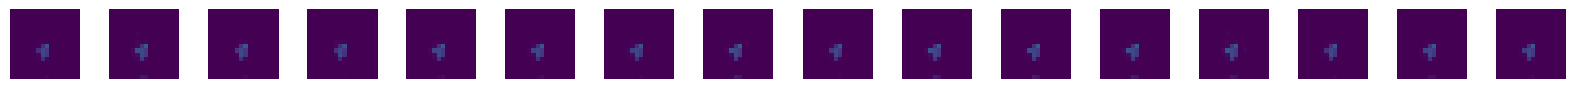

[Epoch 113/300] [D loss: 0.7491] [G loss: 0.0865] [Validity_loss: 0.0854] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0011]
Sample feature coding: [ 0.         -0.225806    0.72124654  0.8640141   0.48386368  0.01075413
  0.029332    0.00374826  0.04455191]


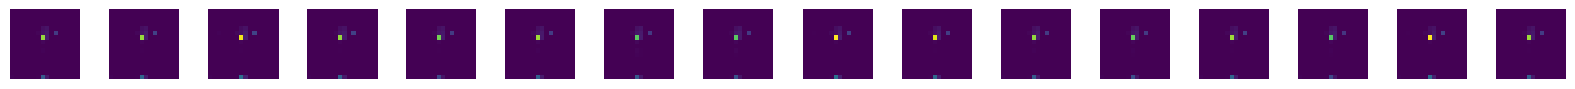

[Epoch 114/300] [D loss: 0.4717] [G loss: 0.1197] [Validity_loss: 0.1189] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [ 0.         -0.45193878  0.15632558  0.4835434   0.48204774  0.00828289
  0.03192608  0.00394768  0.01542732]


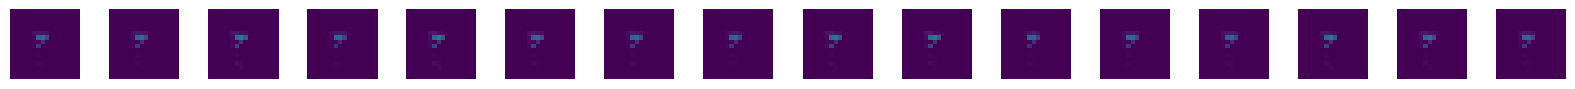

[Epoch 115/300] [D loss: 0.6538] [G loss: 0.0831] [Validity_loss: 0.0812] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0019]
Sample feature coding: [0.         1.2156892  0.10865875 0.42682183 0.6289879  0.0106119
 0.09184305 0.00368027 0.01340126]


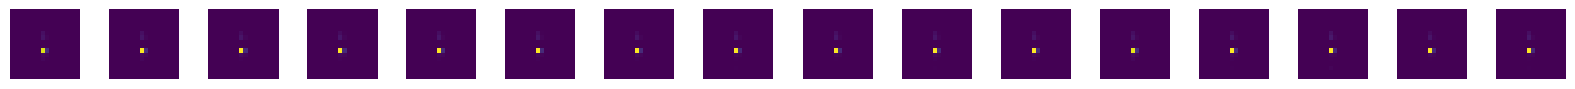

[Epoch 116/300] [D loss: 0.6465] [G loss: 0.0854] [Validity_loss: 0.0848] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 1.         -1.7104933   0.81764686  0.74520624  0.54572433  0.00948739
  0.05079326  0.00376809  0.01625729]


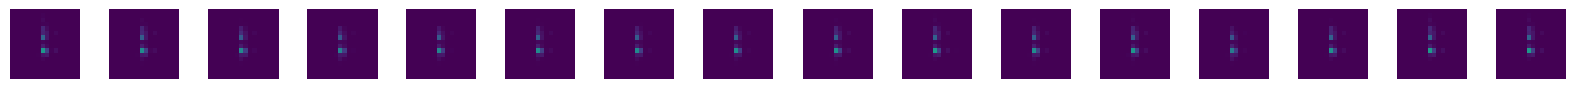

[Epoch 117/300] [D loss: 0.6114] [G loss: 0.0929] [Validity_loss: 0.0922] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         1.5576947  0.05258779 0.13069582 0.85601413 0.0083623
 0.06449974 0.0035667  0.03332143]


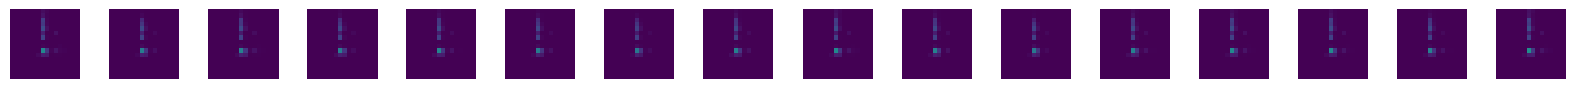

[Epoch 118/300] [D loss: 0.5831] [G loss: 0.1073] [Validity_loss: 0.1066] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [ 1.         -1.097107    0.70605266  0.2903914   0.53846514  0.00554874
  0.05315752  0.00419833  0.0296954 ]


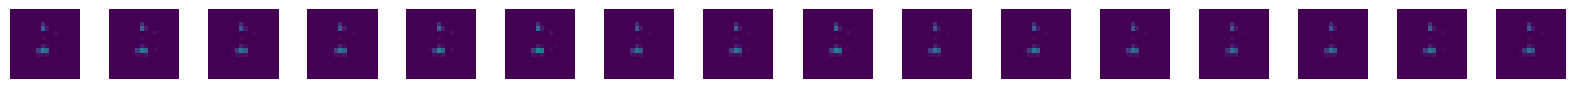

[Epoch 119/300] [D loss: 0.6430] [G loss: 0.0796] [Validity_loss: 0.0790] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -1.1449268   0.01575424  0.33039242  0.5277669   0.00843573
  0.08762995  0.00391575  0.03843242]


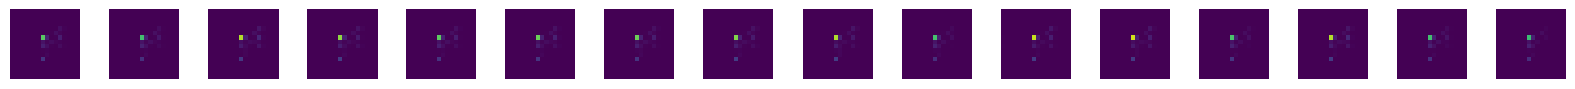

[Epoch 120/300] [D loss: 0.6305] [G loss: 0.0932] [Validity_loss: 0.0924] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         0.94436324 0.08556376 0.22912817 0.47233185 0.01130702
 0.05518368 0.00367366 0.02642386]


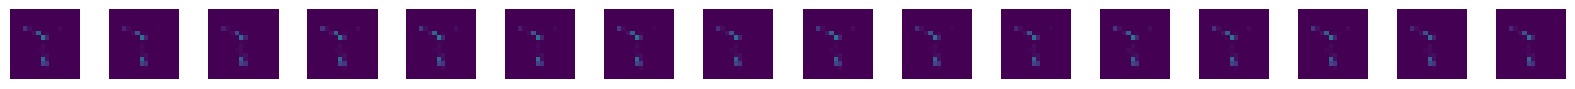

[Epoch 121/300] [D loss: 0.5560] [G loss: 0.0988] [Validity_loss: 0.0981] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [1.         0.5638435  0.5721687  0.29063624 0.8825393  0.0114196
 0.03390481 0.0038076  0.02086213]


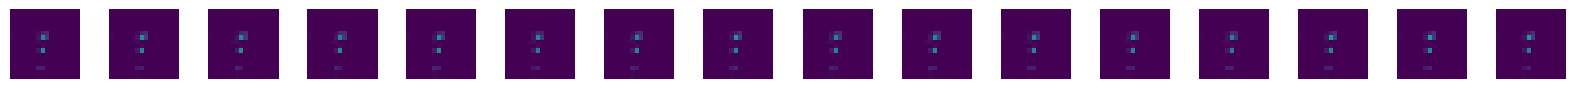

[Epoch 122/300] [D loss: 0.6440] [G loss: 0.0842] [Validity_loss: 0.0837] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0005]
Sample feature coding: [0.         0.3304444  0.85539496 0.29499984 0.51796174 0.00764003
 0.07244109 0.00359255 0.04389268]


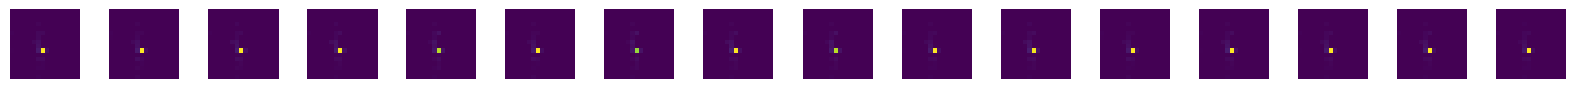

[Epoch 123/300] [D loss: 0.6387] [G loss: 0.0891] [Validity_loss: 0.0884] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         0.61940956 0.50840324 0.5370639  0.85646504 0.00780828
 0.03617756 0.00385971 0.03781798]


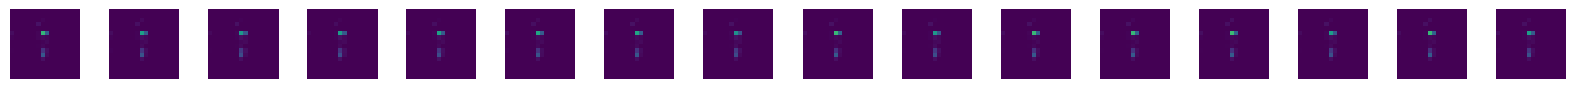

[Epoch 124/300] [D loss: 0.5484] [G loss: 0.1062] [Validity_loss: 0.1056] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [ 0.         -0.42245883  1.02832     0.87297356  0.5042751   0.00996719
  0.03943146  0.00366791  0.0200509 ]


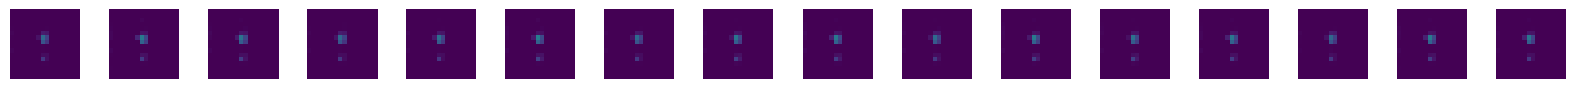

[Epoch 125/300] [D loss: 0.5899] [G loss: 0.1021] [Validity_loss: 0.0986] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0035]
Sample feature coding: [ 1.         -0.3015597   0.47207657  0.462204    0.5094238   0.01061031
  0.06540472  0.00414089  0.02336944]


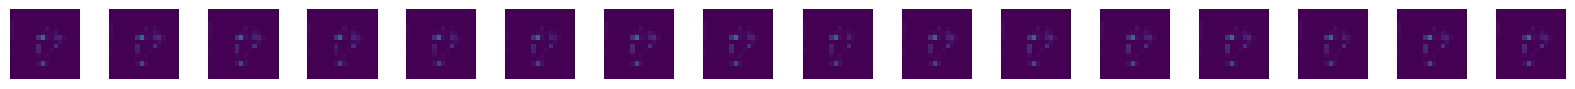

[Epoch 126/300] [D loss: 0.6556] [G loss: 0.0791] [Validity_loss: 0.0785] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.04097123 0.5035054  0.357895   0.44306788 0.01106972
 0.0291515  0.00388623 0.01926238]


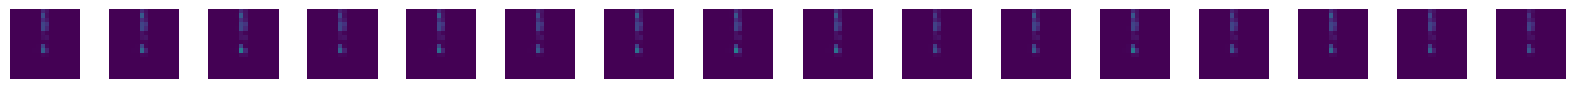

[Epoch 127/300] [D loss: 0.5833] [G loss: 0.1008] [Validity_loss: 0.1001] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         0.06872269 0.29560554 0.55417997 0.50316864 0.0096708
 0.05787984 0.00380375 0.03418299]


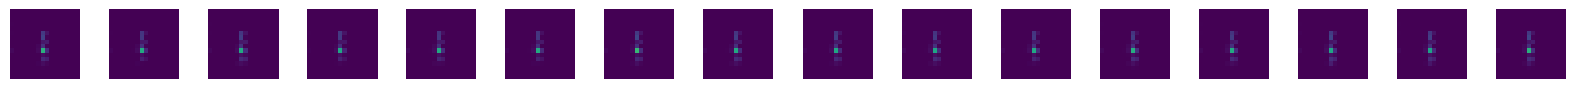

[Epoch 128/300] [D loss: 0.3841] [G loss: 0.1546] [Validity_loss: 0.1530] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0016]
Sample feature coding: [1.         2.0021634  0.8911853  0.6316088  0.6013159  0.00978018
 0.04060809 0.00381133 0.02402686]


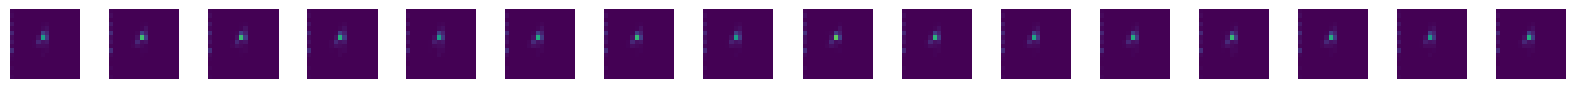

[Epoch 129/300] [D loss: 0.6786] [G loss: 0.0954] [Validity_loss: 0.0941] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0013]
Sample feature coding: [0.         1.0690696  0.7040884  0.39167458 0.92232454 0.01063205
 0.04923224 0.0036944  0.02197542]


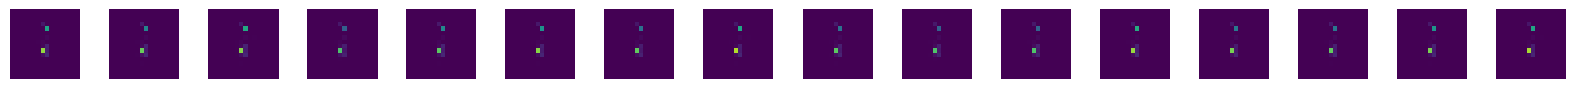

[Epoch 130/300] [D loss: 0.5793] [G loss: 0.1337] [Validity_loss: 0.1324] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0013]
Sample feature coding: [ 1.         -0.6939853   0.9957149   0.43991128  0.87402576  0.00629371
  0.07070812  0.00373261  0.03394414]


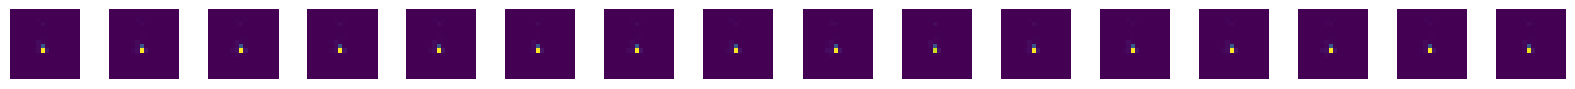

[Epoch 131/300] [D loss: 0.6639] [G loss: 0.0875] [Validity_loss: 0.0835] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0040]
Sample feature coding: [ 0.         -0.00937318  0.4606254   0.60668314  0.53527635  0.01093547
  0.07203642  0.00371071  0.02957963]


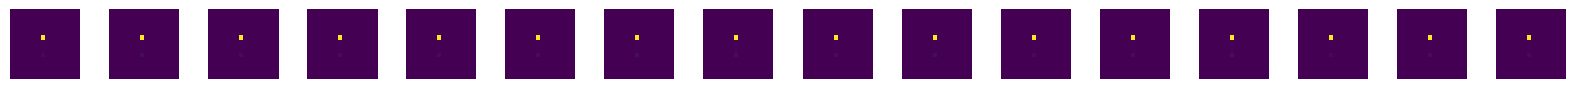

[Epoch 132/300] [D loss: 0.5311] [G loss: 0.1055] [Validity_loss: 0.1040] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0014]
Sample feature coding: [ 1.         -1.7448242   0.16029966  0.02504852  0.44092998  0.00927888
  0.04657245  0.00383058  0.0467113 ]


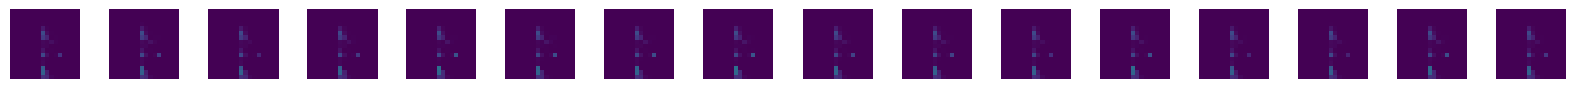

[Epoch 133/300] [D loss: 0.4060] [G loss: 0.1335] [Validity_loss: 0.1329] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0006]
Sample feature coding: [0.         0.68495214 0.69024473 0.73897    0.5987503  0.00997976
 0.05679055 0.00388191 0.01602723]


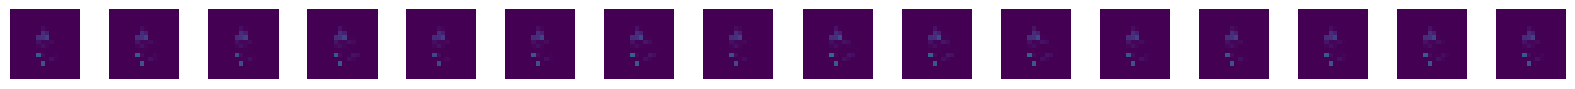

[Epoch 134/300] [D loss: 0.1324] [G loss: 0.2583] [Validity_loss: 0.2577] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         0.24618633 0.3193057  0.60889375 0.49694216 0.00696278
 0.074178   0.00372098 0.01948272]


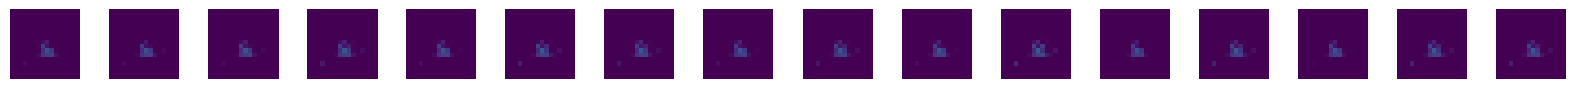

[Epoch 135/300] [D loss: 0.5547] [G loss: 0.0939] [Validity_loss: 0.0934] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0005]
Sample feature coding: [1.         0.65113795 0.07393555 0.43773422 0.50443304 0.01220204
 0.05229007 0.00388137 0.01718446]


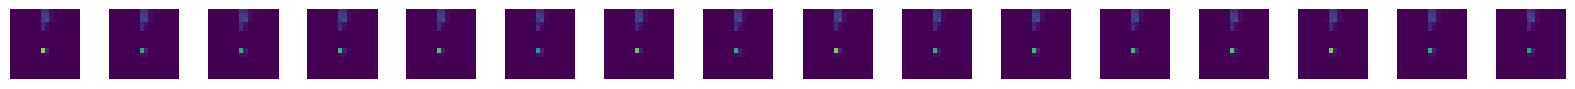

[Epoch 136/300] [D loss: 0.4354] [G loss: 0.1235] [Validity_loss: 0.1228] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [1.         1.5323972  0.03420093 0.20690791 0.5241163  0.00885435
 0.04599684 0.00397148 0.0182118 ]


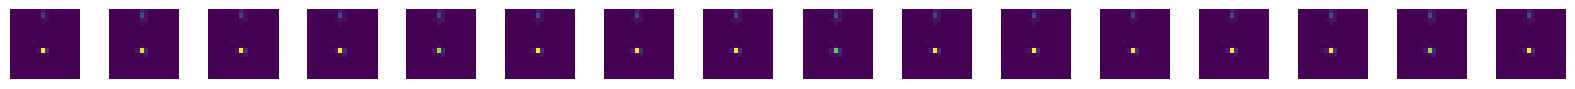

[Epoch 137/300] [D loss: 0.6651] [G loss: 0.0591] [Validity_loss: 0.0583] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0009]
Sample feature coding: [1.         0.02167909 0.2190933  0.44139704 0.6143613  0.00881078
 0.05242623 0.00343751 0.02678634]


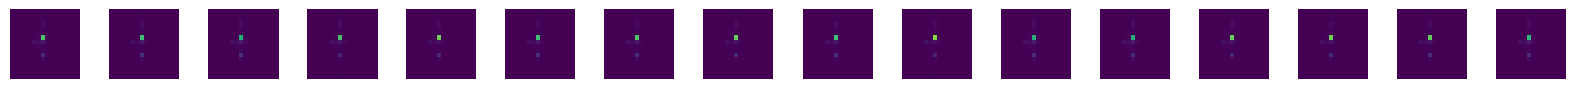

[Epoch 138/300] [D loss: 0.5252] [G loss: 0.0998] [Validity_loss: 0.0989] 
 [Stat_loss: 0.0001] [NNZ_loss: 0.0008]
Sample feature coding: [ 0.         -1.4456918  -0.0329662   0.37307832  0.74889606  0.00815857
  0.07964966  0.00375201  0.02430765]


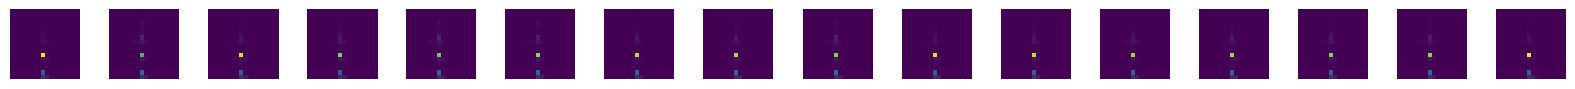

[Epoch 139/300] [D loss: 0.4339] [G loss: 0.1213] [Validity_loss: 0.1202] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0011]
Sample feature coding: [ 1.         -1.0476793   0.9815048   0.3068125   0.84587723  0.00856686
  0.07361469  0.00391872  0.02748281]


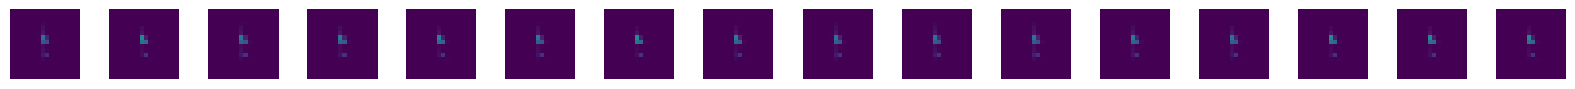

[Epoch 140/300] [D loss: 0.4681] [G loss: 0.1141] [Validity_loss: 0.1133] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0008]
Sample feature coding: [0.         0.6724337  0.43830648 0.327322   0.68981385 0.00930552
 0.0582329  0.00366146 0.01915932]


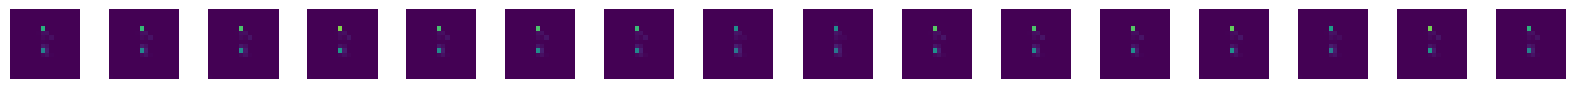

[Epoch 141/300] [D loss: 0.4858] [G loss: 0.1121] [Validity_loss: 0.1114] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [ 1.         -0.5160918   0.37089634  0.49866822  0.90938056  0.00736843
  0.06396881  0.00361686  0.01774348]


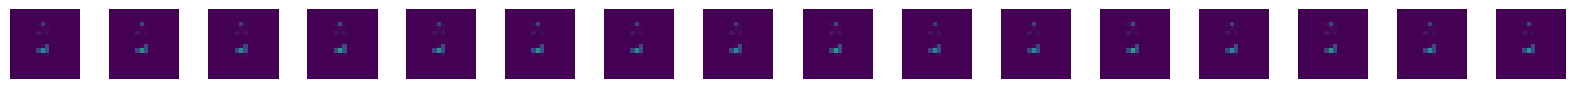

[Epoch 142/300] [D loss: 0.4473] [G loss: 0.1263] [Validity_loss: 0.1256] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0007]
Sample feature coding: [0.         1.3710828  0.52844465 0.60338616 0.611741   0.01065897
 0.07499025 0.00389332 0.03402668]


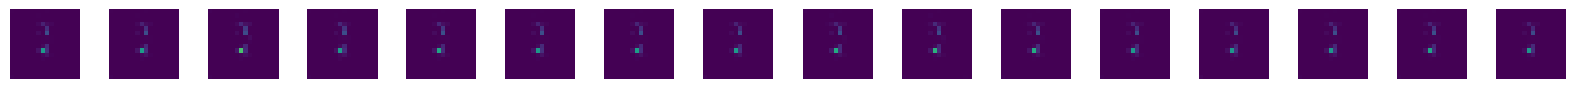

[Epoch 143/300] [D loss: 0.4669] [G loss: 0.1279] [Validity_loss: 0.1268] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0011]
Sample feature coding: [ 1.         -1.881782    0.06096945  0.65388757  0.53713965  0.01113793
  0.06580494  0.00400992  0.03233283]


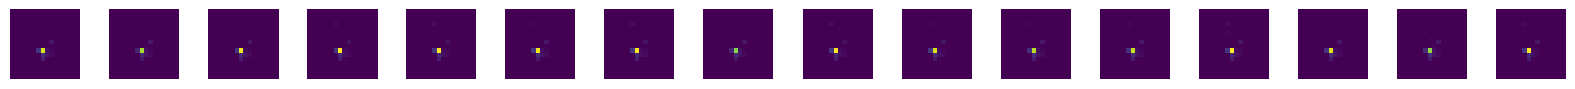

In [ ]:
for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 3 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)


            # real_labels = torch.empty_like(real_pred).uniform_(0.7, 1.2)
            # fake_labels = torch.empty_like(fake_pred).uniform_(0.0, 0.3)
            # labels = (torch.cat([real_labels, fake_labels], dim=0)).cuda()

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)
            
            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists)

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = weights.mean(dim = (1,2))
            fake_pixel_std = weights.std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists)

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = weights.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = weights.squeeze(1).std(dim = (1,2))

            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]


            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl_total += kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / .001
            kl_total += kde_kl_divergence_torch(real_dR_std, fake_dR_std) / .03
            kl_total += kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / .0001
            kl_total += kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / .01

            stat_loss = kl_total

            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .05
            beta = .00001
            chi = .0001

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,5].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,7].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,8].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    z_img = torch.randn(batch_size, 256, 1, 1).cuda()

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

## Last 10 epochs stats
# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # 4 stats

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):
    ax = axs[row]

    real_vals = real_stats[row]
    fake_vals = fake_stats[row]

    # Compute limits
    lower = min(np.percentile(real_vals, 1), np.percentile(fake_vals, 1))
    upper = max(np.percentile(real_vals, 99), np.percentile(fake_vals, 99))

    # Truncate values
    real_vals_trunc = real_vals[(real_vals >= lower) & (real_vals <= upper)]
    fake_vals_trunc = fake_vals[(fake_vals >= lower) & (fake_vals <= upper)]

    # Plot
    ax.hist(real_vals_trunc, bins=1000, alpha=0.6, label='Real',
            edgecolor='black', density=True, histtype='stepfilled')
    ax.hist(fake_vals_trunc, bins=1000, alpha=0.6, label='Fake',
            edgecolor='black', density=True, histtype='stepfilled')

    ax.set_xlim(lower, upper)
    ax.set_title(f"{stat_titles[row]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Statistic", fontsize=16, y=1.02)
plt.show()

## Save Model
# Create output directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Timestamp for unique filenames
timestamp = datetime.now().strftime("m%d_%H%M)

# Save model states and tracked data in a single file
save_path = f"models/Q_gan_model_{timestamp}.pt"
torch.save({
    "generator_state_dict": generator.state_dict(),
    "discriminator_state_dict": discriminator.state_dict(),
    "g_losses": g_losses,
    "d_losses": d_losses,
    "tracked_fake_dR_mean": tracked_fake_dR_mean,
    "tracked_fake_dR_std": tracked_fake_dR_std,
    "tracked_fake_pixel_mean": tracked_fake_pixel_mean,
    "tracked_fake_pixel_std": tracked_fake_pixel_std,
    "tracked_real_dR_mean": tracked_real_dR_mean,
    "tracked_real_dR_std": tracked_real_dR_std,
    "tracked_real_pixel_mean": tracked_real_pixel_mean,
    "tracked_real_pixel_std": tracked_real_pixel_std
}, save_path)

print(f"Model and statistics saved to {save_path}")

![image.png](attachment:7aee3b98-579c-4bcb-9682-eb417b7e3a7a.png)

In [ ]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images[:n_images].min()
vmax = dataset.images[:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [ ]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True